In [1]:
# --- Section 0: Setup and Imports ---
# This section imports all necessary libraries and configures plotting styles.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA # For unsupervised feature engineering

# Supervised Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

# Neural Network (LSTM) - Requires TensorFlow/Keras
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    LSTM_AVAILABLE = True
except ImportError:
    print("TensorFlow/Keras not installed. LSTM model will be skipped.")
    LSTM_AVAILABLE = False

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set plot style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6) # Default figure size
plt.rcParams['lines.linewidth'] = 2 # Make lines a bit thicker for clarity

print("Libraries imported and plot style set.")

# --- Section 1 & 2: Understanding the Problem & Dataset Preparation ---
# This section loads the dataset, performs initial checks, renames columns,
# filters for a specific country (India), sets the time index, and defines
# the initial set of features and labels.
#desired_monthly_cols = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
# 3.5 Box Plots for Monthly Anomalies (to see seasonal distribution differences)
'''if existing_monthly_cols:
    print("\nPlotting Box Plots for Monthly Temperature Anomalies...")
    df_monthly_long = df_filtered[existing_monthly_cols].melt(var_name='Month', value_name='Anomaly')
    
    # Define a custom order for months for correct display
    month_order_full = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    # Filter order to only include months actually present in data
    month_order_present = [m for m in month_order_full if m in existing_monthly_cols]

    plt.figure(figsize=(14, 7))
    sns.boxplot(data=df_monthly_long, x='Month', y='Anomaly', order=month_order_present, palette='coolwarm')
    plt.title('Monthly Temperature Anomaly Distributions', fontsize=16)
    plt.xlabel('Month')
    plt.ylabel('Temperature Anomaly (°C)')
    plt.tight_layout()
    plt.show()
else:
    print("Monthly anomaly columns (JAN-DEC) not found for box plot visualization.")'''

# 5.2 Unsupervised Feature Engineering (PCA on Monthly Anomalies)
pca = None # Initialize pca to None
'''if existing_monthly_cols:
    print(f"\nApplying PCA on monthly anomaly columns: {existing_monthly_cols}")
    monthly_data_for_pca = df_fe[existing_monthly_cols].copy()
    
    # Handle NaNs in monthly data for PCA specifically (PCA cannot handle NaNs)
    # Impute with mean of each monthly column before scaling for PCA
    monthly_data_for_pca = monthly_data_for_pca.fillna(monthly_data_for_pca.mean())

    # Ensure there's enough data for PCA (at least n_components samples if n_components is int)
    if not monthly_data_for_pca.empty and monthly_data_for_pca.shape[0] > 1:
        scaler_monthly_pca = StandardScaler()
        scaled_monthly_data = scaler_monthly_pca.fit_transform(monthly_data_for_pca)

        # Choose n_components ensuring it's not more than the number of features or samples
        n_components_pca = min(3, scaled_monthly_data.shape[1], scaled_monthly_data.shape[0])
        if n_components_pca > 0:
            pca = PCA(n_components=n_components_pca)
            principal_components = pca.fit_transform(scaled_monthly_data)

            for i in range(pca.n_components_):
                df_fe[f'PC{i+1}'] = principal_components[:, i]
            print(f"PCA applied. Explained variance by PCs: {pca.explained_variance_ratio_}")
        else:
            print("Not enough data or features for PCA. Skipping PCA.")
    else:
        print("Monthly data for PCA is empty or has too few samples. Skipping PCA.")
else:
    print("Monthly anomaly columns not found. Skipping PCA for monthly data.")'''

Libraries imported and plot style set.


'if existing_monthly_cols:\n    print(f"\nApplying PCA on monthly anomaly columns: {existing_monthly_cols}")\n    monthly_data_for_pca = df_fe[existing_monthly_cols].copy()\n\n    # Handle NaNs in monthly data for PCA specifically (PCA cannot handle NaNs)\n    # Impute with mean of each monthly column before scaling for PCA\n    monthly_data_for_pca = monthly_data_for_pca.fillna(monthly_data_for_pca.mean())\n\n    # Ensure there\'s enough data for PCA (at least n_components samples if n_components is int)\n    if not monthly_data_for_pca.empty and monthly_data_for_pca.shape[0] > 1:\n        scaler_monthly_pca = StandardScaler()\n        scaled_monthly_data = scaler_monthly_pca.fit_transform(monthly_data_for_pca)\n\n        # Choose n_components ensuring it\'s not more than the number of features or samples\n        n_components_pca = min(3, scaled_monthly_data.shape[1], scaled_monthly_data.shape[0])\n        if n_components_pca > 0:\n            pca = PCA(n_components=n_components_pca)

In [2]:
print("\n--- Section 1 & 2: Understanding the Problem & Dataset Preparation ---")

# Define the path to your dataset
data_file_path = 'update_temperature.csv'

try:
    df = pd.read_csv(data_file_path)
    print(f"Dataset '{data_file_path}' loaded successfully.")
    print(f"Initial shape: {df.shape}")
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nDataset Information (initial):")
    df.info()
    print("\nMissing values per column (initial):")
    print(df.isnull().sum())

except FileNotFoundError:
    print(f"Error: '{data_file_path}' not found. Please ensure the dataset file is in the correct directory.")
    print("If the file name is different, please update 'data_file_path'.")
    raise FileNotFoundError(f"Dataset '{data_file_path}' not found.")


--- Section 1 & 2: Understanding the Problem & Dataset Preparation ---
Dataset 'update_temperature.csv' loaded successfully.
Initial shape: (156, 10)

First 5 rows of the dataset:
   Year        Country  Avg_Temperature_degC  CO2_Emissions_tons_per_capita  \
0  2000  United States                  13.5                           20.2   
1  2000          China                  12.8                            2.7   
2  2000        Germany                   9.3                           10.1   
3  2000         Brazil                  24.9                            1.9   
4  2000      Australia                  21.7                           17.2   

   Sea_Level_Rise_mm  Rainfall_mm  Population  Renewable_Energy_pct  \
0                  0          715   282500000                   6.2   
1                  0          645  1267000000                  16.5   
2                  0          700    82200000                   6.6   
3                  0         1760   175000000               

In [3]:
# **IMPORTANT: Rename columns to standardized names**
# Adjust these renames based on the actual column names in your 'update_temperature.csv' file.
# If a column doesn't exist, it will be skipped with a warning.
column_mapping = {
    'Year': 'Year', # Ensure 'Year' column is correctly identified
    'Country': 'Country', # Ensure 'Country' column is correctly identified
    'Avg_Temperature_degC': 'Avg_Temperature_C',
    'CO2_Emissions_tons_per_capita': 'CO2_Emissions_Per_Capita',
    'Sea_Level_Rise_mm': 'Sea_Level_Rise_mm',
    'Rainfall_mm': 'Rainfall_mm',
    'Extreme_Weather_Events': 'Extreme_Weather_Events_Count',
    'Population_Total': 'Population',
    'Renewable_Energy_Percentage': 'Renewable_Energy_pct',
    'Forest_Area_Percentage': 'Forest_Area_pct',
}

In [4]:
# Apply renaming, skipping keys if column not found
renamed_cols = {}
for old_name, new_name in column_mapping.items():
    if old_name in df.columns:
        renamed_cols[old_name] = new_name
    elif new_name in df.columns and old_name != new_name: # Check if new name already exists as old name
        print(f"Warning: Column '{old_name}' not found, but '{new_name}' already exists. Skipping rename for this column.")
df.rename(columns=renamed_cols, inplace=True)
print("\nColumns renamed for consistency (please verify mappings).")


Columns renamed for consistency (please verify mappings).


In [5]:
# Filter for 'India' (or your region of interest)
# Adjust if you want to analyze a different country or all countries
if 'Country' in df.columns:
    df_filtered = df[df['Country'] == 'India'].copy()
    if df_filtered.empty:
        print("Warning: No data found for 'Country' == 'India'. Using entire dataset.")
        df_filtered = df.copy()
else:
    df_filtered = df.copy() # If no 'Country' column, use the whole dataset
    print("No 'Country' column found. Using the entire dataset.")
print(f"Filtered DataFrame shape: {df_filtered.shape}")

Filtered DataFrame shape: (12, 10)


In [6]:
# Ensure 'Year' is a datetime index and sorted
if 'Year' in df_filtered.columns:
    df_filtered['Year'] = pd.to_datetime(df_filtered['Year'], format='%Y', errors='coerce')
    df_filtered.dropna(subset=['Year'], inplace=True) # Remove rows where Year couldn't be parsed
    df_filtered.set_index('Year', inplace=True)
    df_filtered.sort_index(inplace=True)
    print("Set 'Year' as datetime index and sorted data.")
else:
    print("Error: 'Year' column not found or could not be parsed. Cannot set time index.")
    raise ValueError("Missing or invalid 'Year' column in the dataset.")

Set 'Year' as datetime index and sorted data.


In [7]:
# Define the initial set of features and labels based on the problem description.
# These are the *desired* features/labels. Their existence will be checked.
desired_features_initial = [
    'Avg_Temperature_C', 'CO2_Emissions_Per_Capita', 'Rainfall_mm',
    'Population', 'Renewable_Energy_pct', 'Forest_Area_pct'
]
desired_labels = [
    'Temperature_Anomaly_C', # Will be engineered if Avg_Temperature_C exists
    'Sea_Level_Rise_mm',
    'Extreme_Weather_Events_Count'
]

In [8]:
# Create a working DataFrame with only the relevant and existing columns
existing_features = [f for f in desired_features_initial if f in df_filtered.columns]
existing_labels_direct = [l for l in desired_labels if l in df_filtered.columns and l != 'Temperature_Anomaly_C']
#existing_monthly_cols = [m for m in desired_monthly_cols if m in df_filtered.columns]

df_working = df_filtered[existing_features + existing_labels_direct].copy()

if not existing_features:
    print("Error: No initial features found in the dataset after filtering/renaming. Please check column names.")
    raise ValueError("No valid features for modeling.")
if not existing_labels_direct and 'Avg_Temperature_C' not in df_working.columns:
    print("Error: No direct labels found and 'Avg_Temperature_C' is missing for anomaly calculation.")
    raise ValueError("No valid labels for modeling.")

In [9]:
# Calculate Temperature Anomaly (Label Engineering - part of initial setup)
if 'Avg_Temperature_C' in df_working.columns:
    baseline_start_year = df_working.index.min().year
    # Ensure baseline calculation has enough data
    if len(df_working) >= 10:
        baseline_end_year = min(baseline_start_year + 9, df_working.index.max().year)
    else: # If less than 10 years, use available data for baseline
        baseline_end_year = df_working.index.max().year
        print(f"Warning: Less than 10 years of data available. Baseline calculated from {len(df_working)} years.")

    baseline_temp_df = df_working[(df_working.index.year >= baseline_start_year) & (df_working.index.year <= baseline_end_year)]
    if not baseline_temp_df.empty:
        baseline_temp = baseline_temp_df['Avg_Temperature_C'].mean()
        df_working['Temperature_Anomaly_C'] = df_working['Avg_Temperature_C'] - baseline_temp
        print(f"Calculated Temperature_Anomaly_C relative to {baseline_start_year}-{baseline_end_year} baseline ({baseline_temp:.2f}°C).")
        if 'Temperature_Anomaly_C' not in existing_labels_direct:
            existing_labels_direct.append('Temperature_Anomaly_C')
    else:
        print("Warning: Could not calculate baseline temperature (empty baseline data). 'Temperature_Anomaly_C' will be NaN.")
        df_working['Temperature_Anomaly_C'] = np.nan
else:
    print("Warning: 'Avg_Temperature_C' not found. Cannot calculate 'Temperature_Anomaly_C'.")
    df_working['Temperature_Anomaly_C'] = np.nan # Ensure column exists even if NaN

# Update labels_for_models to reflect what's actually available
labels_for_models = [l for l in desired_labels if l in df_working.columns]

print(f"\nActual features being used: {existing_features}")
print(f"Actual labels being used: {labels_for_models}")
print(f"Working DataFrame shape: {df_working.shape}")
print("Working DataFrame Info (after initial processing):")
df_working.info()

Calculated Temperature_Anomaly_C relative to 2000-2009 baseline (24.55°C).

Actual features being used: ['Avg_Temperature_C', 'CO2_Emissions_Per_Capita', 'Rainfall_mm', 'Population', 'Renewable_Energy_pct', 'Forest_Area_pct']
Actual labels being used: ['Temperature_Anomaly_C', 'Sea_Level_Rise_mm', 'Extreme_Weather_Events_Count']
Working DataFrame shape: (12, 9)
Working DataFrame Info (after initial processing):
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2000-01-01 to 2024-01-01
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg_Temperature_C             12 non-null     float64
 1   CO2_Emissions_Per_Capita      12 non-null     float64
 2   Rainfall_mm                   12 non-null     int64  
 3   Population                    12 non-null     int64  
 4   Renewable_Energy_pct          12 non-null     float64
 5   Forest_Area_pct               12 non-null    

In [10]:
# --- Section 3: Data Exploration and Visualization ---
# This section visualizes key trends, distributions, and relationships.

print("\n--- Section 3: Data Exploration and Visualization ---")

# 3.1 Descriptive Statistics
print("\nDescriptive statistics for the working dataset:")
print(df_working.describe())


--- Section 3: Data Exploration and Visualization ---

Descriptive statistics for the working dataset:
       Avg_Temperature_C  CO2_Emissions_Per_Capita  Rainfall_mm    Population  \
count          12.000000                 12.000000    12.000000  1.200000e+01   
mean           25.083333                  1.416667  1066.416667  1.258592e+09   
std             0.483986                  0.423907    48.897775  1.342150e+08   
min            24.400000                  0.800000   985.000000  1.056600e+09   
25%            24.675000                  0.975000  1042.000000  1.147075e+09   
50%            25.100000                  1.500000  1067.500000  1.271650e+09   
75%            25.500000                  1.800000  1108.750000  1.380000e+09   
max            25.800000                  1.900000  1128.000000  1.425800e+09   

       Renewable_Energy_pct  Forest_Area_pct  Sea_Level_Rise_mm  \
count             12.000000        12.000000          12.000000   
mean              24.975000     


Plotting time series for key indicators...


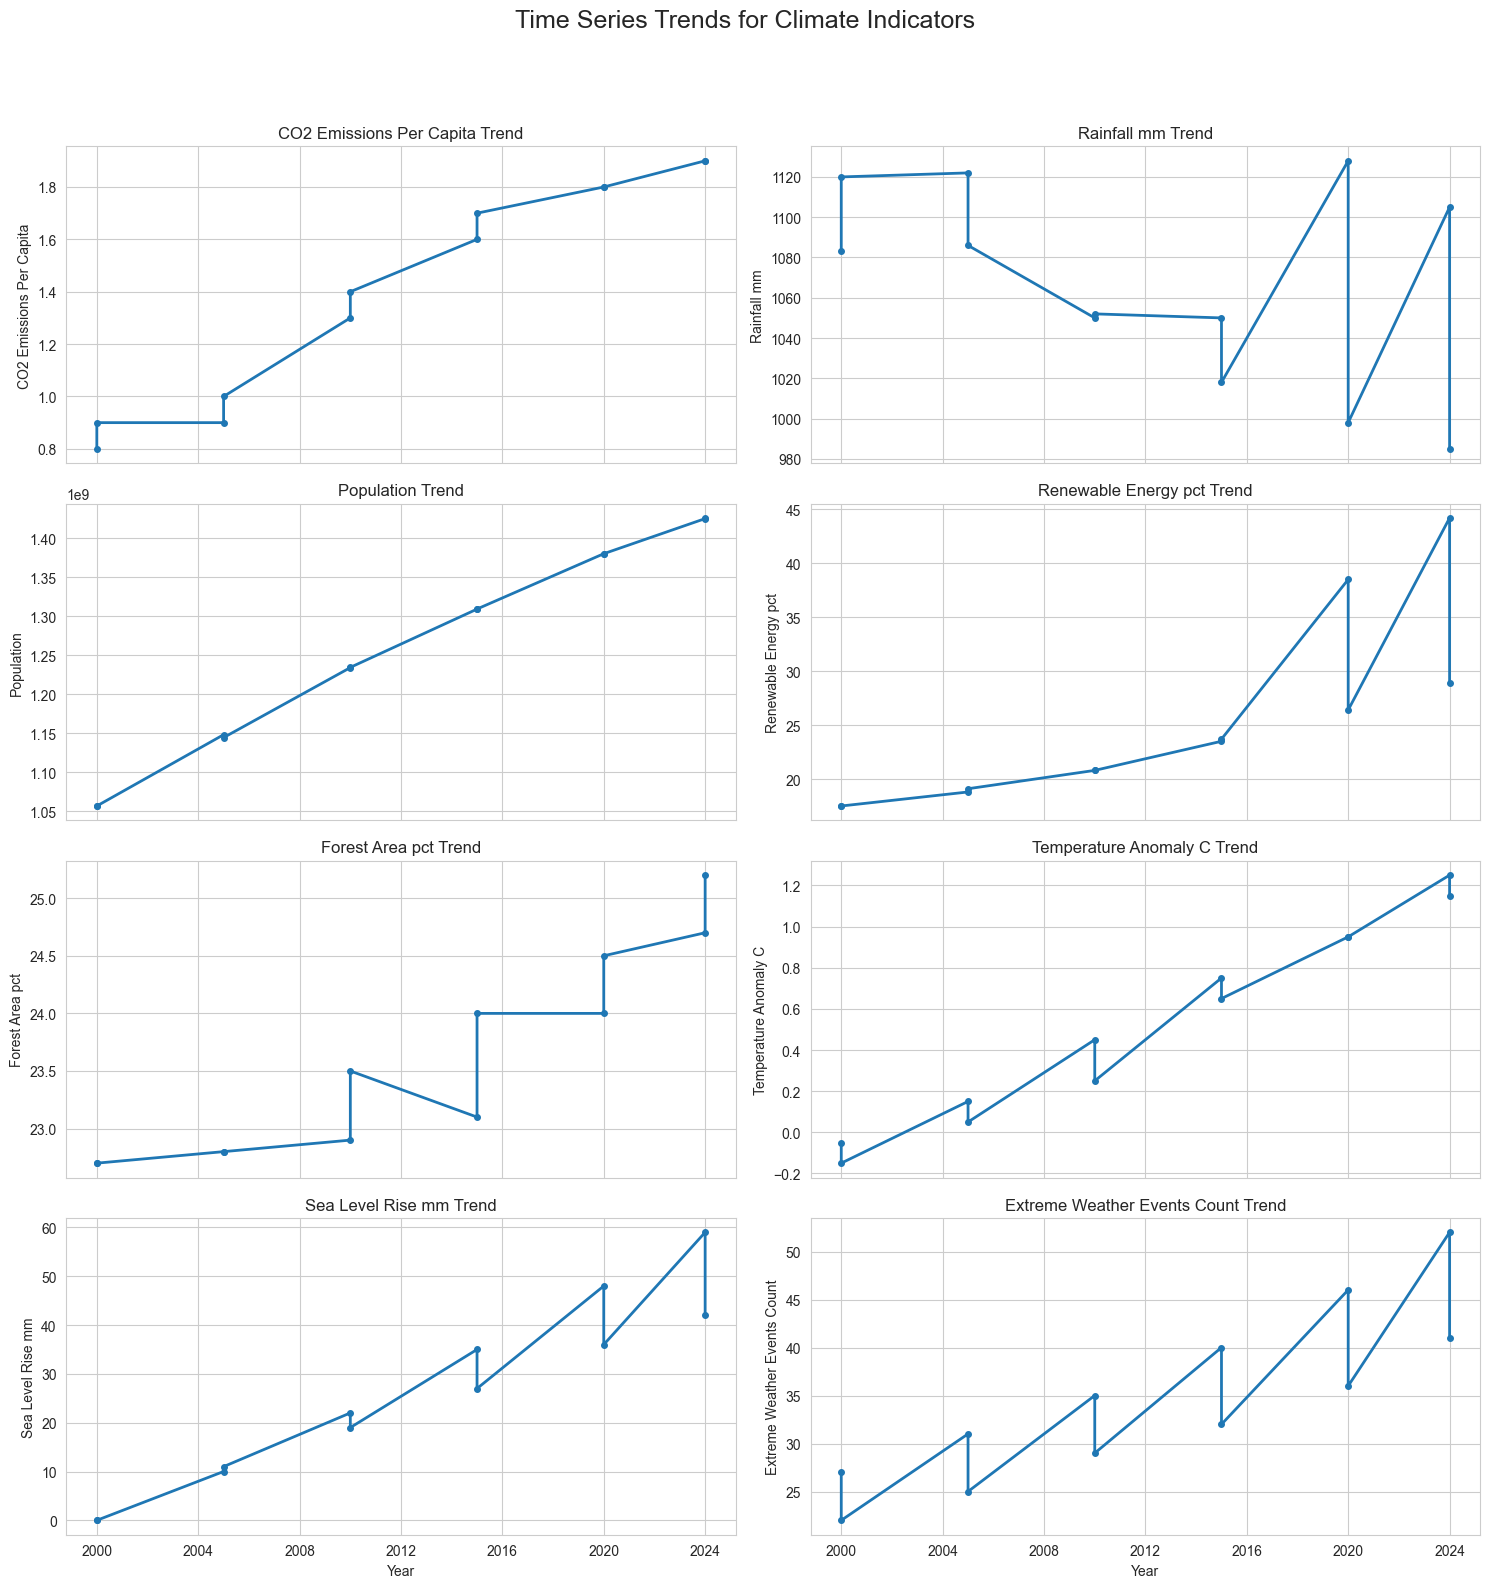

In [11]:
# 3.2 Time Series Plots for key features and labels
print("\nPlotting time series for key indicators...")
plot_cols_ts = [col for col in existing_features + labels_for_models if col in df_working.columns and col != 'Avg_Temperature_C']
if plot_cols_ts:
    n_plots_ts = len(plot_cols_ts)
    n_cols_ts = 2
    n_rows_ts = (n_plots_ts + n_cols_ts - 1) // n_cols_ts

    fig_ts, axes_ts = plt.subplots(n_rows_ts, n_cols_ts, figsize=(15, n_rows_ts * 4), sharex=True)
    axes_ts = axes_ts.flatten()

    for i, col in enumerate(plot_cols_ts):
        ax = axes_ts[i]
        ax.plot(df_working.index, df_working[col], marker='o', linestyle='-', markersize=4)
        ax.set_title(f'{col.replace("_", " ")} Trend')
        ax.set_ylabel(col.replace("_", " "))
        ax.grid(True)
        if i >= n_plots_ts - n_cols_ts: # Only add x-label to bottom plots
            ax.set_xlabel('Year')
        else:
            ax.tick_params(axis='x', labelbottom=False)

    for j in range(i + 1, len(axes_ts)):
        fig_ts.delaxes(axes_ts[j])

    fig_ts.suptitle('Time Series Trends for Climate Indicators', fontsize=18, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
else:
    print("No relevant columns found for time series plotting.")



Plotting Correlation Matrix...


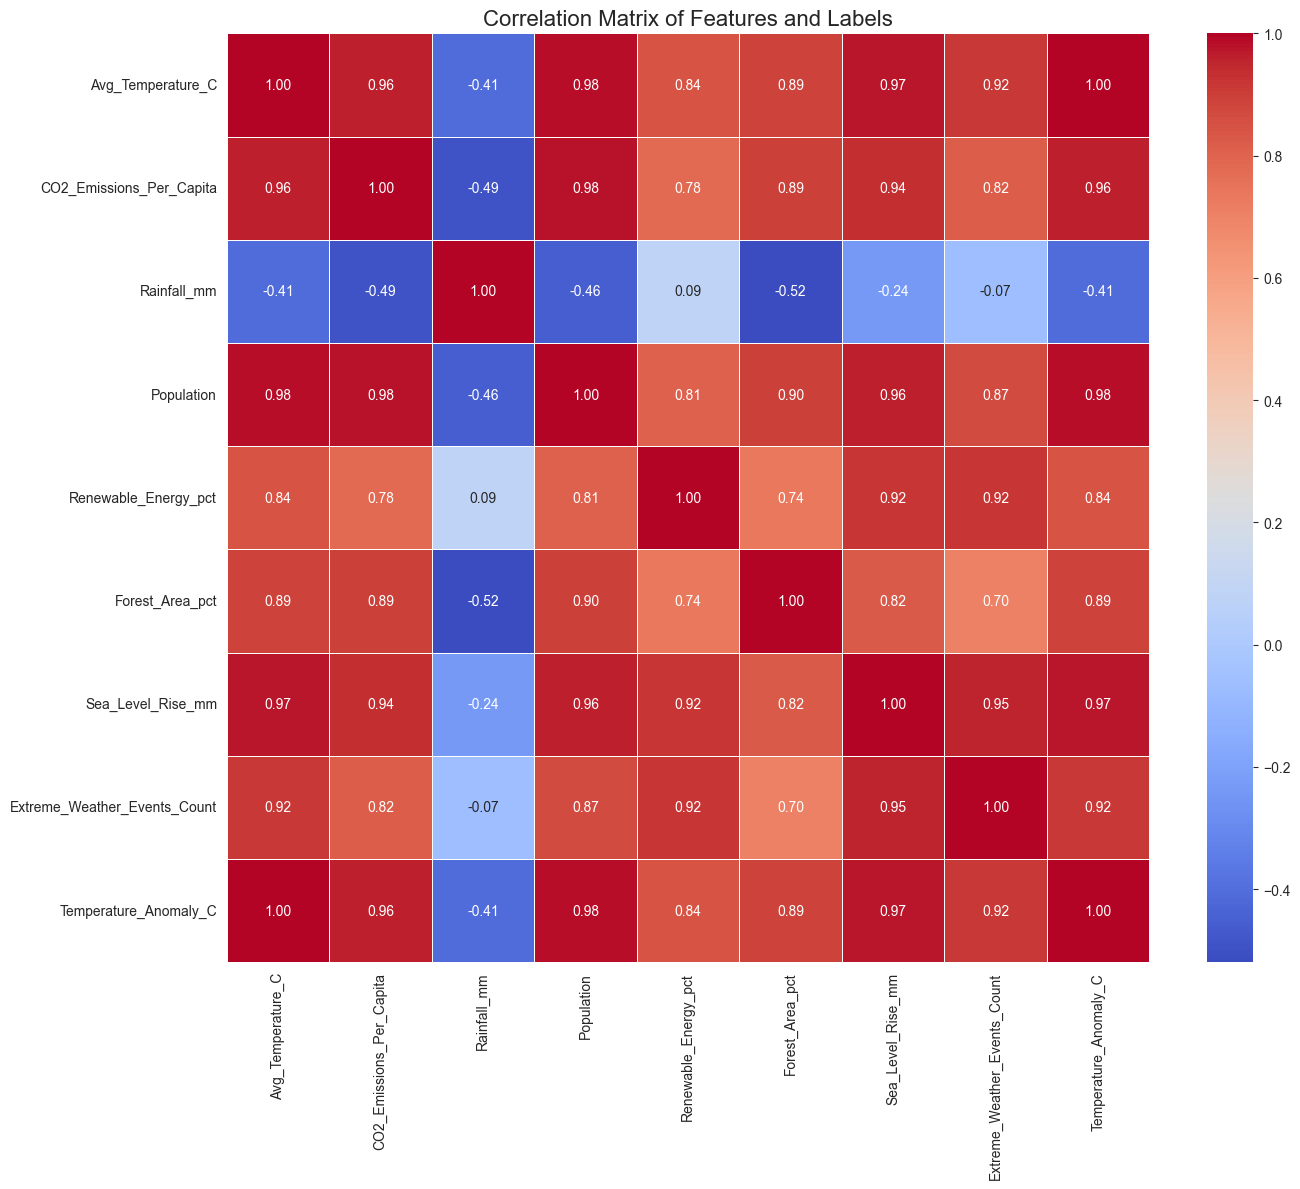

In [12]:
# 3.3 Correlation Matrix (Heatmap)
print("\nPlotting Correlation Matrix...")
numerical_data_for_corr = df_working.select_dtypes(include=np.number)
if not numerical_data_for_corr.empty and numerical_data_for_corr.shape[1] > 1:
    plt.figure(figsize=(14, 12))
    sns.heatmap(numerical_data_for_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Features and Labels', fontsize=16)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numerical data (or only one column) to plot correlation matrix.")



Plotting Histograms for key distributions...


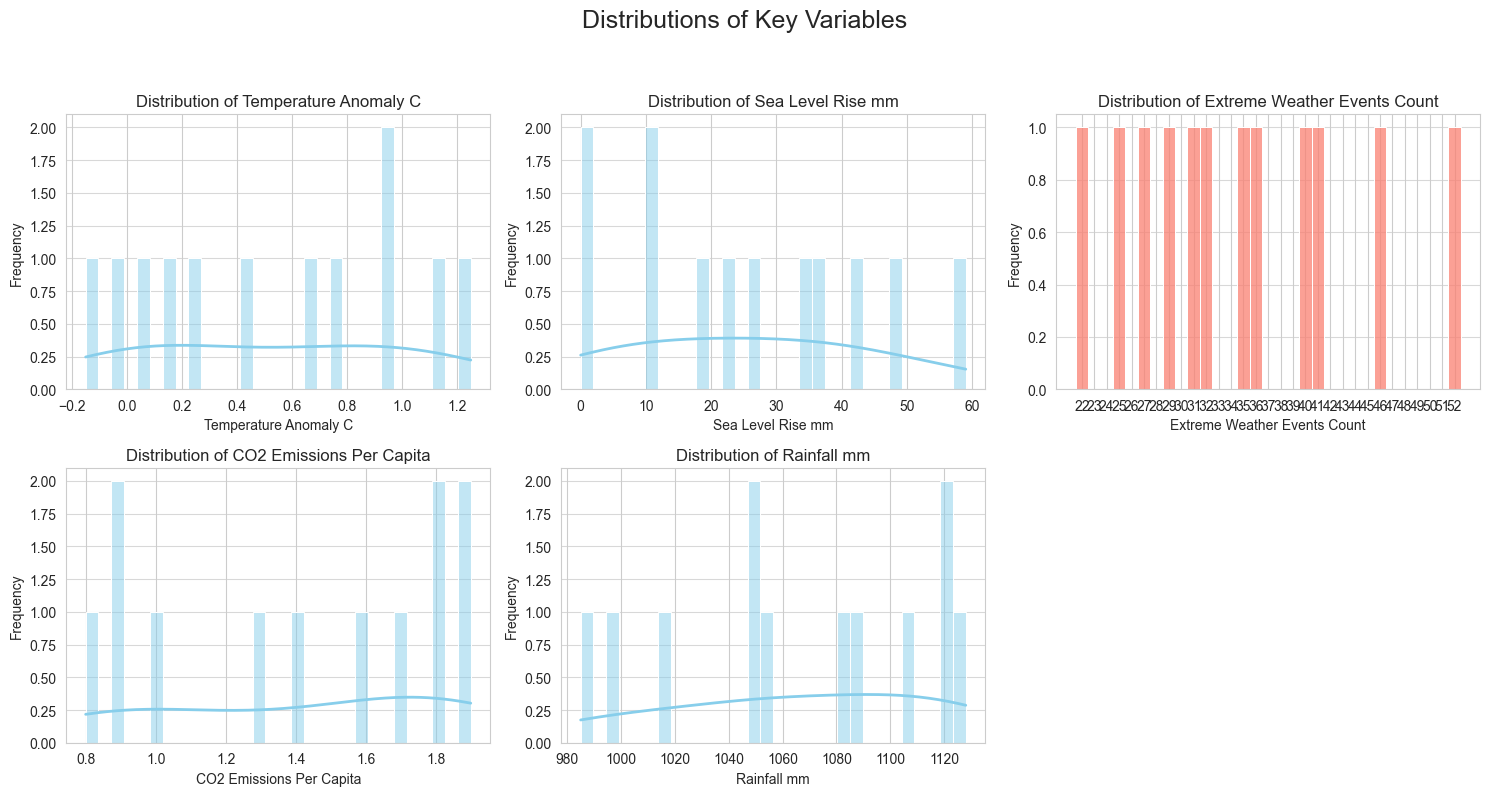

In [13]:
# 3.4 Histograms for Distributions
print("\nPlotting Histograms for key distributions...")
histogram_cols = [col for col in labels_for_models + ['CO2_Emissions_Per_Capita', 'Rainfall_mm'] if col in df_working.columns]
if histogram_cols:
    n_plots_hist = len(histogram_cols)
    n_cols_hist = 3
    n_rows_hist = (n_plots_hist + n_cols_hist - 1) // n_cols_hist

    fig_hist, axes_hist = plt.subplots(n_rows_hist, n_cols_hist, figsize=(n_cols_hist * 5, n_rows_hist * 4))
    axes_hist = axes_hist.flatten()

    for i, col in enumerate(histogram_cols):
        ax = axes_hist[i]
        if col == 'Extreme_Weather_Events_Count':
            # Ensure bins are appropriate for integer counts
            if not df_working[col].dropna().empty:
                bins = np.arange(df_working[col].min(), df_working[col].max() + 2) - 0.5
                sns.histplot(data=df_working, x=col, bins=bins, kde=False, stat='count', discrete=True, ax=ax, color='salmon')
                ax.set_xticks(np.arange(df_working[col].min(), df_working[col].max() + 1))
            else:
                ax.text(0.5, 0.5, 'No data for bins', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        else:
            sns.histplot(data=df_working, x=col, bins=30, kde=True, ax=ax, color='skyblue')
        ax.set_title(f'Distribution of {col.replace("_", " ")}')
        ax.set_xlabel(col.replace("_", " "))
        ax.set_ylabel('Frequency')
        ax.grid(axis='y', alpha=0.75)

    for j in range(i + 1, len(axes_hist)):
        fig_hist.delaxes(axes_hist[j])

    fig_hist.suptitle('Distributions of Key Variables', fontsize=18, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
else:
    print("No numerical columns found for histogram plotting.")


In [14]:
# --- Section 4: Data Preprocessing (Pipeline Definition) ---
# This section defines the preprocessing pipeline components.
# Actual application happens after feature engineering and splitting.

print("\n--- Section 4: Data Preprocessing (Pipeline Definition) ---")

# Preprocessing pipeline for numerical features (Imputation + Scaling)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute with mean
    ('scaler', StandardScaler()) # Standardize
])
print("Preprocessing pipeline (Imputer + StandardScaler) for numerical features defined.")

# Note: Categorical encoding is mentioned in the description but not used here
# as the assumed dataset primarily contains numerical time-series data.
# If you have categorical features (e.g., 'Season', 'Event_Type'), you would add:
# from sklearn.preprocessing import OneHotEncoder
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])
# And include it in the ColumnTransformer.


--- Section 4: Data Preprocessing (Pipeline Definition) ---
Preprocessing pipeline (Imputer + StandardScaler) for numerical features defined.


In [15]:
# --- Section 5: Feature Engineering ---
# This section creates new features (rolling averages, lagged variables)
# and integrates unsupervised learning (PCA) for dimensionality reduction.

print("\n--- Section 5: Feature Engineering ---")

# Create a copy for feature engineering
df_fe = df_working.copy()

# 5.1 Time-Series Specific Features

# Add 'Year_Numerical' as a simple trend feature
df_fe['Year_Numerical'] = (df_fe.index.year - df_fe.index.min().year).astype(float)
print("Trend feature 'Year_Numerical' created.")


--- Section 5: Feature Engineering ---
Trend feature 'Year_Numerical' created.


In [16]:
# Lagged Features (e.g., previous 1, 2, 3 years for Temperature_Anomaly_C and initial features)
lag_periods = [1, 2, 3] # Example lags
features_to_lag = [col for col in existing_features + ['Temperature_Anomaly_C'] if col in df_fe.columns]

for lag in lag_periods:
    for feature in features_to_lag:
        df_fe[f'{feature}_lag_{lag}'] = df_fe[feature].shift(lag)
print(f"Lagged features created for {features_to_lag}.")

Lagged features created for ['Avg_Temperature_C', 'CO2_Emissions_Per_Capita', 'Rainfall_mm', 'Population', 'Renewable_Energy_pct', 'Forest_Area_pct', 'Temperature_Anomaly_C'].


In [17]:
# Rolling Averages/Statistics (e.g., 3-year, 5-year rolling mean/std of Temperature_Anomaly_C)
rolling_windows = [3, 5]
if 'Temperature_Anomaly_C' in df_fe.columns:
    for window in rolling_windows:
        # Shift by 1 to ensure no data leakage from the current year
        df_fe[f'Temperature_Anomaly_C_rolling_mean_{window}yr'] = df_fe['Temperature_Anomaly_C'].rolling(window=window).mean().shift(1)
        df_fe[f'Temperature_Anomaly_C_rolling_std_{window}yr'] = df_fe['Temperature_Anomaly_C'].rolling(window=window).std().shift(1)
    print("Rolling average/std features created for 'Temperature_Anomaly_C'.")
else:
    print("Warning: 'Temperature_Anomaly_C' not available, skipping rolling features for it.")


Rolling average/std features created for 'Temperature_Anomaly_C'.


In [18]:
# 5.3 Define Final Features for Modeling
# This list will contain all the features (initial, lagged, rolling, PCA) that will be used by the models.
final_features_for_modeling = []
final_features_for_modeling.append('Year_Numerical')

# Add lagged features
for lag in lag_periods:
    for feature in features_to_lag: # Use the list of features that were actually lagged
        if f'{feature}_lag_{lag}' in df_fe.columns:
            final_features_for_modeling.append(f'{feature}_lag_{lag}')

# Add rolling features
if 'Temperature_Anomaly_C' in df_fe.columns:
    for window in rolling_windows:
        if f'Temperature_Anomaly_C_rolling_mean_{window}yr' in df_fe.columns:
            final_features_for_modeling.append(f'Temperature_Anomaly_C_rolling_mean_{window}yr')
        if f'Temperature_Anomaly_C_rolling_std_{window}yr' in df_fe.columns:
            final_features_for_modeling.append(f'Temperature_Anomaly_C_rolling_std_{window}yr')

# Add PCA components if they were created
if pca is not None and pca.n_components_ > 0:
    for i in range(pca.n_components_):
        if f'PC{i+1}' in df_fe.columns:
            final_features_for_modeling.append(f'PC{i+1}')

# Remove duplicates and ensure all selected features exist in df_fe
final_features_for_modeling = list(set([f for f in final_features_for_modeling if f in df_fe.columns]))
print(f"\nFinal list of features for modeling ({len(final_features_for_modeling)}): {final_features_for_modeling}")

# 5.4 Handle NaNs introduced by Feature Engineering (CRITICAL STEP)
# Drop rows where any of the final features have NaN values.
print(f"\nDataFrame shape BEFORE dropping NaNs from FE: {df_fe.shape}")
print(f"DataFrame index range BEFORE dropping NaNs from FE: {df_fe.index.min().year if not df_fe.empty else 'N/A'}-{df_fe.index.max().year if not df_fe.empty else 'N/A'}")



Final list of features for modeling (26): ['Temperature_Anomaly_C_lag_2', 'Temperature_Anomaly_C_lag_3', 'CO2_Emissions_Per_Capita_lag_1', 'Renewable_Energy_pct_lag_3', 'Forest_Area_pct_lag_1', 'Avg_Temperature_C_lag_2', 'Rainfall_mm_lag_2', 'Avg_Temperature_C_lag_3', 'Temperature_Anomaly_C_rolling_std_5yr', 'Temperature_Anomaly_C_lag_1', 'Forest_Area_pct_lag_2', 'Population_lag_3', 'CO2_Emissions_Per_Capita_lag_3', 'Rainfall_mm_lag_1', 'Renewable_Energy_pct_lag_2', 'Temperature_Anomaly_C_rolling_mean_5yr', 'Forest_Area_pct_lag_3', 'Rainfall_mm_lag_3', 'Renewable_Energy_pct_lag_1', 'Year_Numerical', 'Temperature_Anomaly_C_rolling_std_3yr', 'Temperature_Anomaly_C_rolling_mean_3yr', 'Population_lag_2', 'Avg_Temperature_C_lag_1', 'Population_lag_1', 'CO2_Emissions_Per_Capita_lag_2']

DataFrame shape BEFORE dropping NaNs from FE: (12, 35)
DataFrame index range BEFORE dropping NaNs from FE: 2000-2024


In [19]:
if not final_features_for_modeling:
    raise ValueError("No final features identified for modeling after feature engineering. Cannot proceed.")

initial_rows_after_fe = len(df_fe)
df_fe.dropna(subset=final_features_for_modeling, inplace=True)
print(f"DataFrame after dropping NaNs from feature engineering (lost {initial_rows_after_fe - len(df_fe)} rows).")
print(f"New starting year for modeling: {df_fe.index.min().year if not df_fe.empty else 'N/A'}")
print(f"DataFrame shape AFTER dropping NaNs from FE: {df_fe.shape}")
print(f"DataFrame index range AFTER dropping NaNs from FE: {df_fe.index.min().year if not df_fe.empty else 'N/A'}-{df_fe.index.max().year if not df_fe.empty else 'N/A'}")

if df_fe.empty:
    raise ValueError("DataFrame is empty after feature engineering and NaN handling. Cannot proceed with modeling. "
                     "Consider reducing lags/rolling windows or using a longer dataset.")


DataFrame after dropping NaNs from feature engineering (lost 5 rows).
New starting year for modeling: 2010
DataFrame shape AFTER dropping NaNs from FE: (7, 35)
DataFrame index range AFTER dropping NaNs from FE: 2010-2024


In [20]:
# Re-define X and Y based on the cleaned and engineered df_fe
X = df_fe[final_features_for_modeling]
Y = df_fe[labels_for_models]

In [21]:
# --- Section 4.3 (Revisited): Data Splitting ---
# This section now performs the chronological split on the prepared data.

print("\n--- Section 4.3: Data Splitting (Chronological) ---")

# --- Section 4.3 (Revisited): Data Splitting ---
# This section now performs the chronological split on the prepared data.

print("\n--- Section 4.3: Data Splitting (Chronological) ---")

total_samples_available = len(X)

# Define desired split ratios (e.g., 70% train, 15% validation, 15% test)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure minimum data for each split (at least 1 sample per split if possible)
if total_samples_available < 3:
    raise ValueError(f"Not enough data ({total_samples_available} samples) for train/val/test split. Need at least 3 samples.")

# Calculate split indices based on sample counts
train_split_idx = int(total_samples_available * train_ratio)
val_split_idx = int(total_samples_available * (train_ratio + val_ratio))

# Ensure each split gets at least one sample and indices are within bounds
if train_split_idx == 0: # Ensure train set has at least one sample
    train_split_idx = 1
if val_split_idx <= train_split_idx and total_samples_available > train_split_idx: # Ensure val starts after train
    val_split_idx = train_split_idx + 1
if val_split_idx >= total_samples_available: # Ensure val_split_idx doesn't exceed total_samples
    val_split_idx = total_samples_available - 1 # Make test set 1 sample if needed

# If after adjustments, test_split_idx is still too small, adjust val_split_idx further
if total_samples_available - val_split_idx < 1:
    val_split_idx = total_samples_available - 1
    if val_split_idx <= train_split_idx: # If still no space for val, make train and test at least 1
        train_split_idx = max(1, total_samples_available - 2)
        val_split_idx = total_samples_available - 1


# Perform the actual splits using .iloc for robustness
X_train = X.iloc[:train_split_idx]
Y_train = Y.iloc[:train_split_idx]

X_val = X.iloc[train_split_idx:val_split_idx]
Y_val = Y.iloc[train_split_idx:val_split_idx]

X_test = X.iloc[val_split_idx:]
Y_test = Y.iloc[val_split_idx:]


# Final checks for empty splits
if X_train.empty or Y_train.empty:
    raise ValueError("Training set is empty after splitting. Adjust split ratios or provide more data.")
if X_val.empty or Y_val.empty:
    print("Warning: Validation set is empty. Model evaluation might be less robust.")
if X_test.empty or Y_test.empty:
    print("Warning: Test set is empty. Final model evaluation might be skipped or inaccurate.")


print(f"\nData split (adjusted for availability):")
print(f"Train set: {X_train.index.min().year if not X_train.empty else 'N/A'}-{X_train.index.max().year if not X_train.empty else 'N/A'} ({len(X_train)} samples), Shape: {X_train.shape}")
print(f"Validation set: {X_val.index.min().year if not X_val.empty else 'N/A'}-{X_val.index.max().year if not X_val.empty else 'N/A'} ({len(X_val)} samples), Shape: {X_val.shape}")
print(f"Test set: {X_test.index.min().year if not X_test.empty else 'N/A'}-{X_test.index.max().year if not X_test.empty else 'N/A'} ({len(X_test)} samples), Shape: {X_test.shape}")


# Apply preprocessing (fit on train, transform all)
# The preprocessor needs to be defined with the final_features_for_modeling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, final_features_for_modeling)
    ],
    remainder='passthrough'
)

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Convert processed arrays back to DataFrames for consistency and feature names
X_train_processed_df = pd.DataFrame(X_train_processed, columns=final_features_for_modeling, index=X_train.index)
X_val_processed_df = pd.DataFrame(X_val_processed, columns=final_features_for_modeling, index=X_val.index)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=final_features_for_modeling, index=X_test.index)
print("Final data preprocessing (imputation and scaling) applied to splits.")



--- Section 4.3: Data Splitting (Chronological) ---

--- Section 4.3: Data Splitting (Chronological) ---

Data split (adjusted for availability):
Train set: 2010-2020 (4 samples), Shape: (4, 26)
Validation set: 2020-2020 (1 samples), Shape: (1, 26)
Test set: 2024-2024 (2 samples), Shape: (2, 26)
Final data preprocessing (imputation and scaling) applied to splits.


In [22]:
# --- Section 6: Model Selection and Training ---
# This section defines and trains various regression models for each prediction label.

print("\n--- Section 6: Model Selection and Training ---")

# Define the models to train
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'XGBoostRegressor': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    'LightGBMRegressor': lgb.LGBMRegressor(objective='regression', n_estimators=100, random_state=42)
}

trained_models = {}

# Train models for each label (Temperature_Anomaly_C, Sea_Level_Rise_mm, Extreme_Weather_Events_Count)
for label in labels_for_models:
    print(f"\n--- Training models for label: {label} ---")
    y_train = Y_train[label]
    y_val = Y_val[label]

    if X_train_processed_df.empty or y_train.empty:
        print(f"Skipping training for {label}: Training data is empty.")
        continue

    # Traditional ML Models
    for model_name, model_instance in models.items():
        print(f"  Training {model_name}...")
        model_instance.fit(X_train_processed_df, y_train)
        trained_models[f'{label}_{model_name}'] = model_instance

        # Evaluate on validation set if available
        if not X_val_processed_df.empty and not y_val.empty:
            val_preds = model_instance.predict(X_val_processed_df)
            val_mae = mean_absolute_error(y_val, val_preds)
            val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
            val_r2 = r2_score(y_val, val_preds)
            print(f"    Validation MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R2: {val_r2:.4f}")
        else:
            print("    Validation set is empty, skipping validation evaluation.")

    # LSTM Model (if TensorFlow/Keras is available)
    if LSTM_AVAILABLE:
        print(f"  Training LSTM Model for {label}...")
        n_features_lstm = X_train_processed_df.shape[1]
        X_train_lstm = X_train_processed_df.values.reshape(X_train_processed_df.shape[0], 1, n_features_lstm)
        
        # Ensure validation data is not empty for LSTM training
        if not X_val_processed_df.empty:
            X_val_lstm = X_val_processed_df.values.reshape(X_val_processed_df.shape[0], 1, n_features_lstm)
            validation_data_lstm = (X_val_lstm, y_val)
        else:
            X_val_lstm = np.array([]) # Empty array for consistency
            validation_data_lstm = None
            print("    Validation set is empty, LSTM will train without validation data.")


        lstm_model = Sequential([
            LSTM(50, activation='relu', input_shape=(1, n_features_lstm)),
            Dense(1)
        ])
        lstm_model.compile(optimizer='adam', loss='mse')

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) if validation_data_lstm else None

        history = lstm_model.fit(X_train_lstm, y_train, epochs=200, batch_size=1,
                                 validation_data=validation_data_lstm,
                                 callbacks=[early_stopping] if early_stopping else None, verbose=0)

        trained_models[f'{label}_LSTM'] = lstm_model

        # Evaluate LSTM on validation set if available
        if not X_val_processed_df.empty and not y_val.empty:
            val_preds_lstm = lstm_model.predict(X_val_lstm).flatten()
            val_mae_lstm = mean_absolute_error(y_val, val_preds_lstm)
            val_rmse_lstm = np.sqrt(mean_squared_error(y_val, val_preds_lstm))
            val_r2_lstm = r2_score(y_val, val_preds_lstm)
            print(f"    LSTM Validation MAE: {val_mae_lstm:.4f}, RMSE: {val_rmse_lstm:.4f}, R2: {val_r2_lstm:.4f}")
        else:
            print("    Validation set is empty, skipping LSTM validation evaluation.")
    else:
        print("  LSTM model skipped (TensorFlow/Keras not available).")



--- Section 6: Model Selection and Training ---

--- Training models for label: Temperature_Anomaly_C ---
  Training LinearRegression...
    Validation MAE: 0.2193, RMSE: 0.2193, R2: nan
  Training DecisionTreeRegressor...
    Validation MAE: 0.3000, RMSE: 0.3000, R2: nan
  Training RandomForestRegressor...


c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


    Validation MAE: 0.1430, RMSE: 0.1430, R2: nan
  Training XGBoostRegressor...


c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


    Validation MAE: 0.2000, RMSE: 0.2000, R2: nan
  Training LightGBMRegressor...
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 4, number of used features: 0
[LightGBM] [Info] Start training from score 0.650000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
    LSTM Validation MAE: 0.1399, RMSE: 0.1399, R2: nan

--- Training models for label: Sea_Level_Rise_mm ---
  Training LinearRegression...
    Validation MAE: 1.2927, RMSE: 1.2927, R2: nan
  Training DecisionTreeRegressor...
    Validation MAE: 1.0000, RMSE: 1.0000, R2: nan
  Training RandomForestRegressor...


c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Apurva gosa

    Validation MAE: 4.0300, RMSE: 4.0300, R2: nan
  Training XGBoostRegressor...
    Validation MAE: 0.9999, RMSE: 0.9999, R2: nan
  Training LightGBMRegressor...
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 4, number of used features: 0
[LightGBM] [Info] Start training from score 32.250000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped t

c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Validation MAE: 3.7500, RMSE: 3.7500, R2: nan
  Training LSTM Model for Sea_Level_Rise_mm...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
    LSTM Validation MAE: 0.4548, RMSE: 0.4548, R2: nan

--- Training models for label: Extreme_Weather_Events_Count ---
  Training LinearRegression...
    Validation MAE: 0.6909, RMSE: 0.6909, R2: nan
  Training DecisionTreeRegressor...
    Validation MAE: 4.0000, RMSE: 4.0000, R2: nan
  Training RandomForestRegressor...


c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


    Validation MAE: 4.4000, RMSE: 4.4000, R2: nan
  Training XGBoostRegressor...


c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    Validation MAE: 3.9999, RMSE: 3.9999, R2: nan
  Training LightGBMRegressor...
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 4, number of used features: 0
[LightGBM] [Info] Start training from score 36.750000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightG

c:\Users\Apurva gosavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



--- Section 7: Model Evaluation ---

--- Evaluating models for label: Temperature_Anomaly_C on Test Set ---
  LinearRegression (Test Set) - MAE: 44.2449, RMSE: 44.4910, R2: -791779.6528


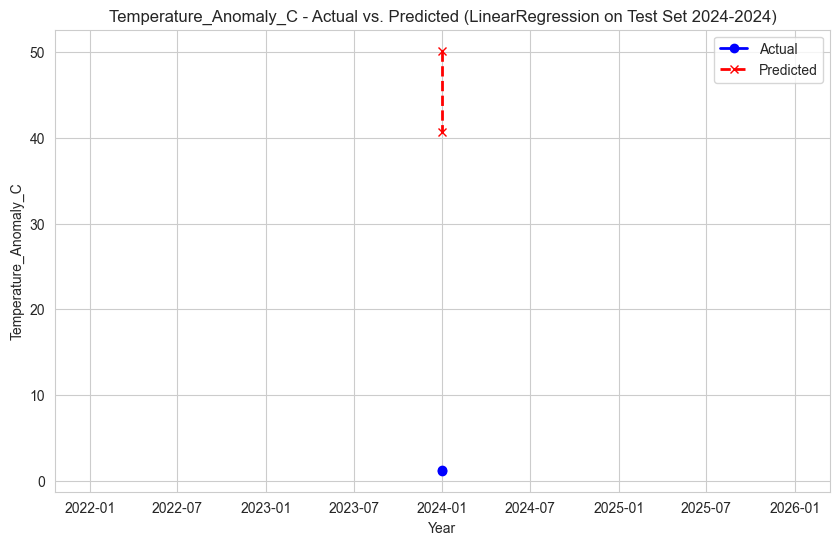

  DecisionTreeRegressor (Test Set) - MAE: 34.8000, RMSE: 35.0349, R2: -490976.0000


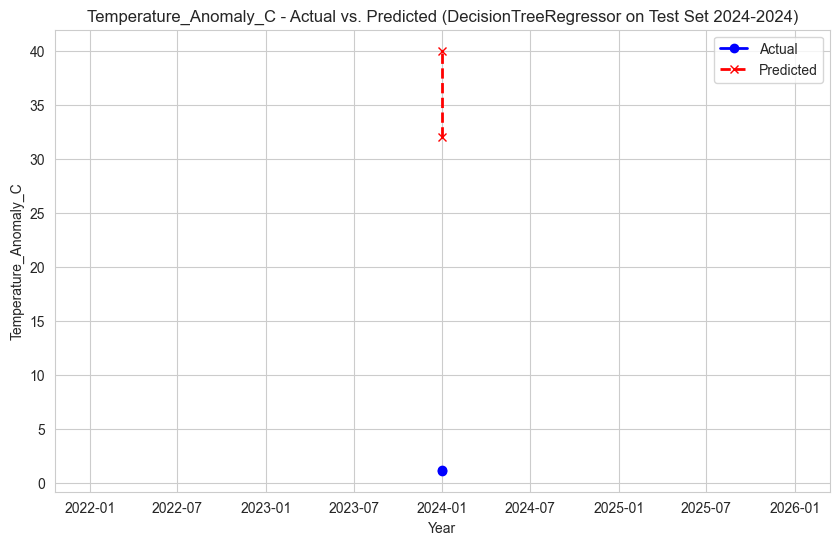

  RandomForestRegressor (Test Set) - MAE: 38.8300, RMSE: 38.8330, R2: -603198.7200


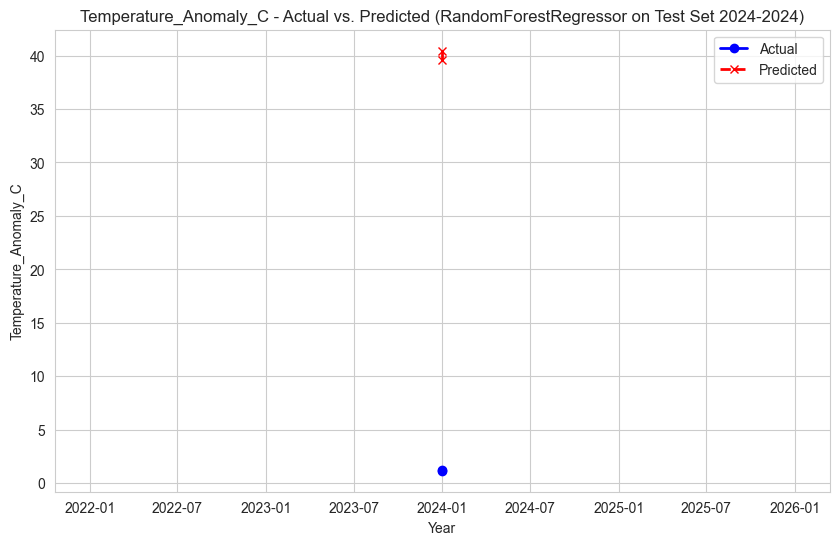

  XGBoostRegressor (Test Set) - MAE: 44.7989, RMSE: 44.7990, R2: -802777.7192


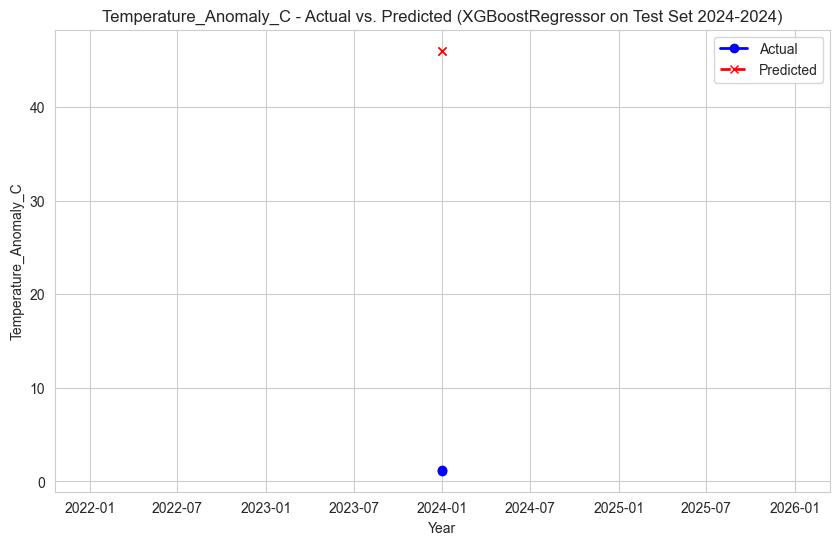

  LightGBMRegressor (Test Set) - MAE: 35.5500, RMSE: 35.5500, R2: -505521.0000


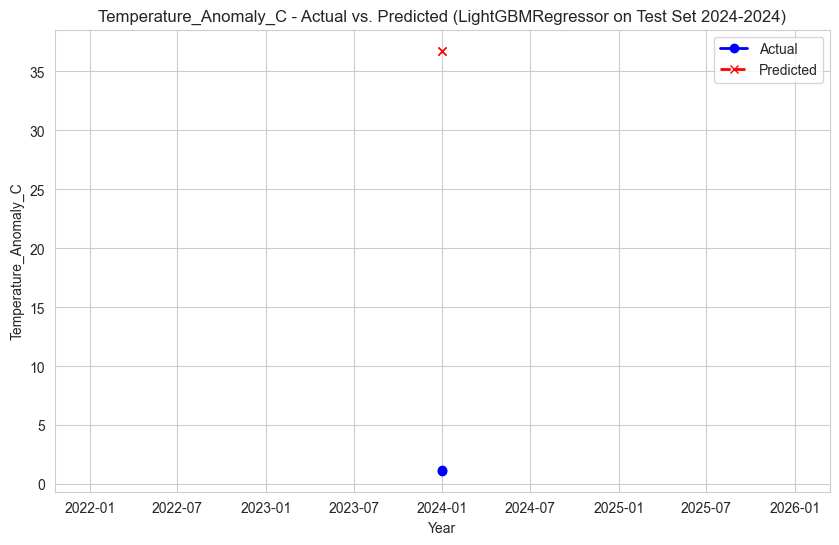

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
  LSTM (Test Set) - MAE: 0.0916, RMSE: 0.0972, R2: -2.7797


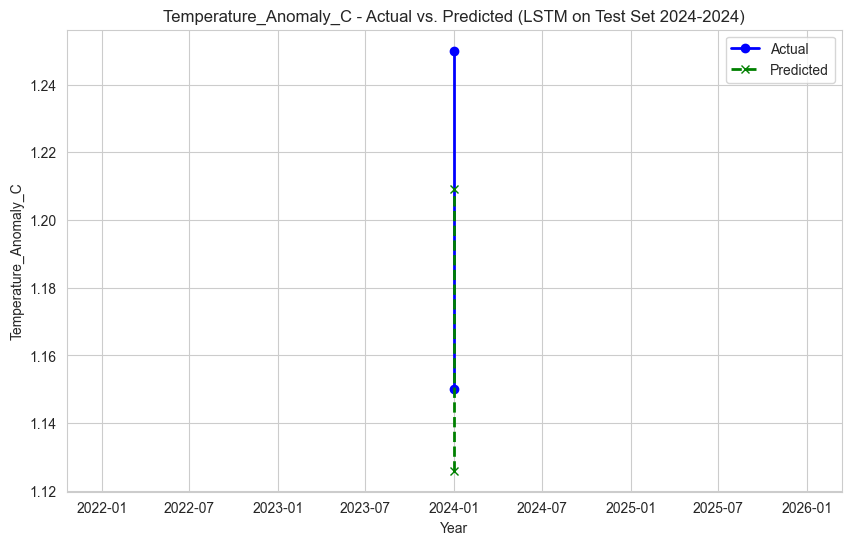


--- Evaluating models for label: Sea_Level_Rise_mm on Test Set ---
  LinearRegression (Test Set) - MAE: 5.0551, RMSE: 6.3099, R2: 0.4489


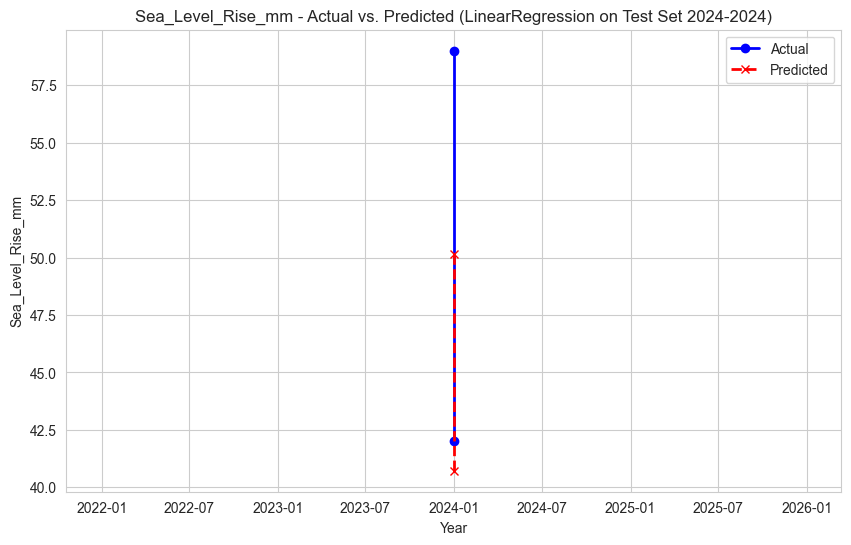

  DecisionTreeRegressor (Test Set) - MAE: 14.5000, RMSE: 19.1442, R2: -4.0727


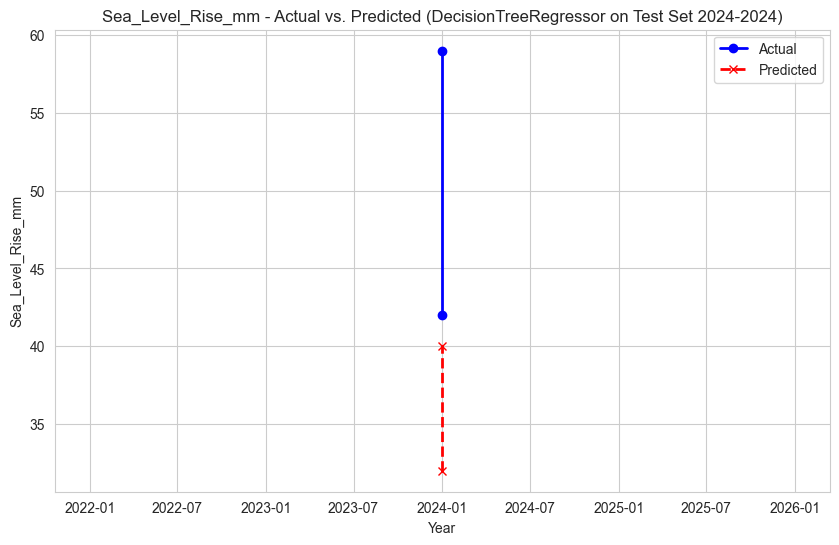

  RandomForestRegressor (Test Set) - MAE: 10.4700, RMSE: 13.7610, R2: -1.6210


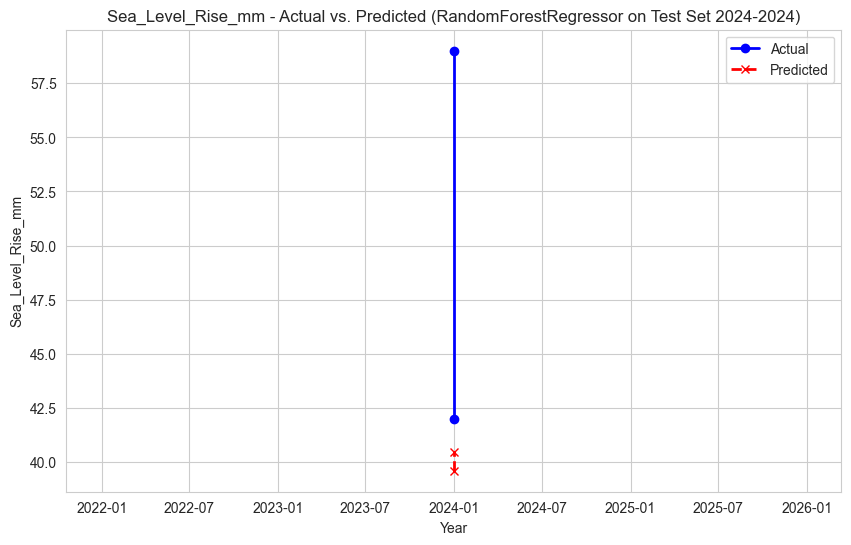

  XGBoostRegressor (Test Set) - MAE: 8.5000, RMSE: 9.6182, R2: -0.2804


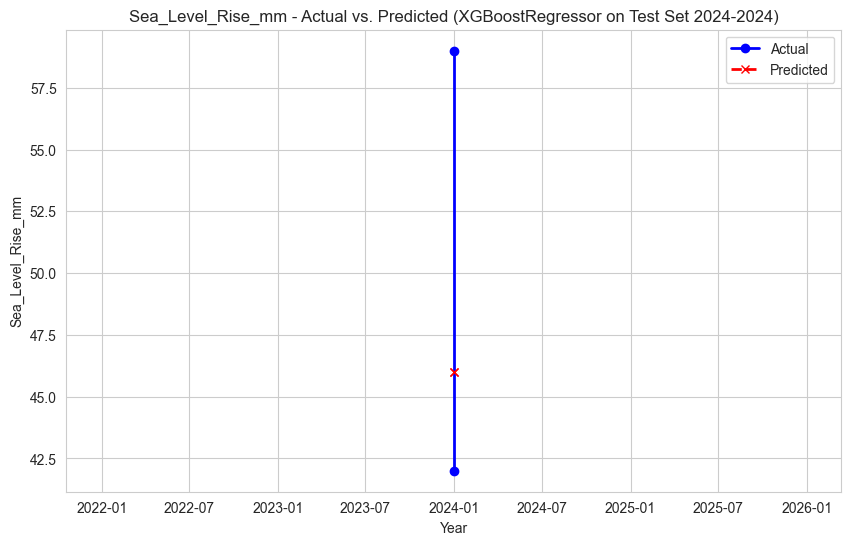

  LightGBMRegressor (Test Set) - MAE: 13.7500, RMSE: 16.1652, R2: -2.6168


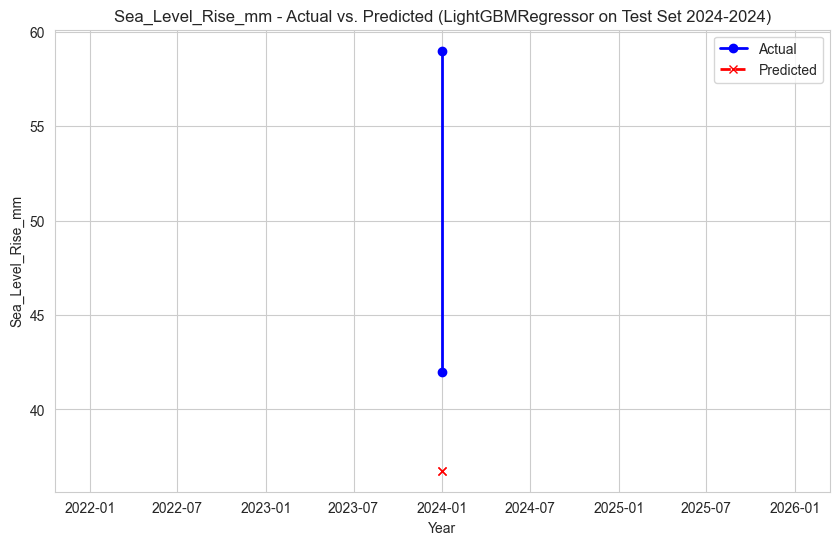

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
  LSTM (Test Set) - MAE: 20.5290, RMSE: 20.8494, R2: -5.0166


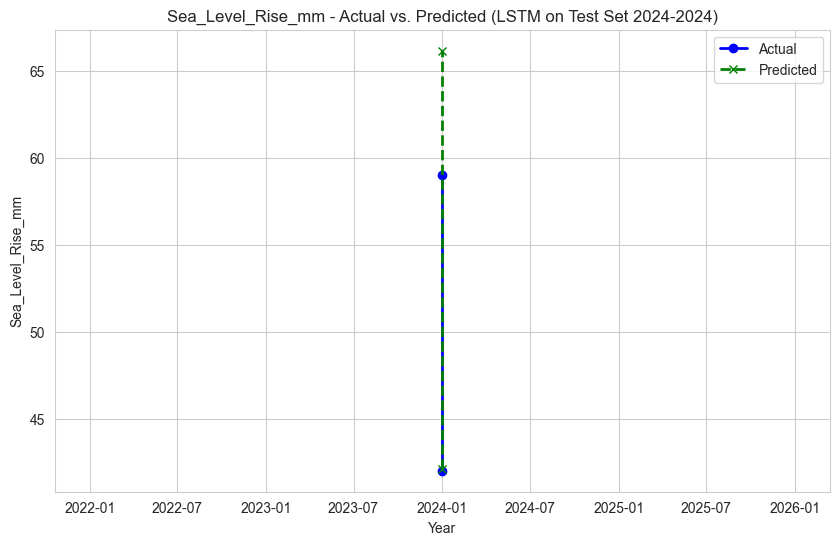


--- Evaluating models for label: Extreme_Weather_Events_Count on Test Set ---
  LinearRegression (Test Set) - MAE: 1.0551, RMSE: 1.3099, R2: 0.9433


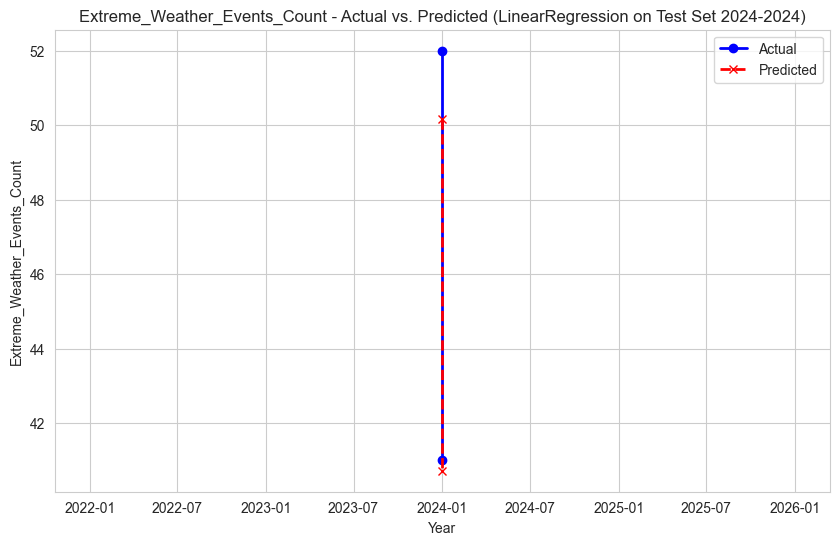

  DecisionTreeRegressor (Test Set) - MAE: 10.5000, RMSE: 14.1598, R2: -5.6281


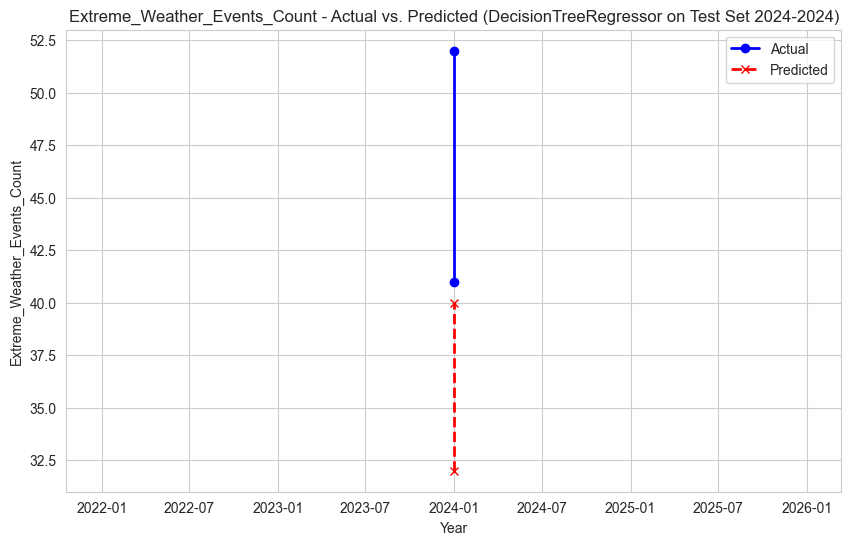

  RandomForestRegressor (Test Set) - MAE: 6.4700, RMSE: 8.7764, R2: -1.5463


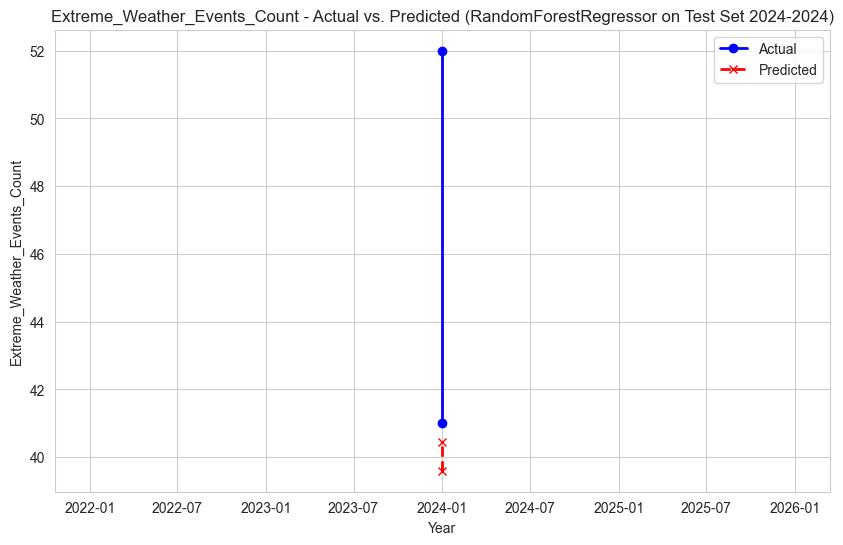

  XGBoostRegressor (Test Set) - MAE: 5.5000, RMSE: 5.5228, R2: -0.0083


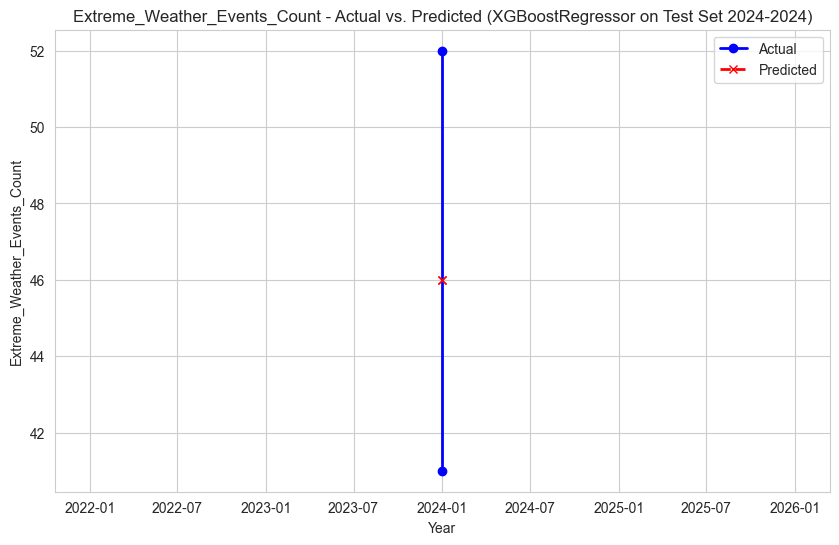

  LightGBMRegressor (Test Set) - MAE: 9.7500, RMSE: 11.1943, R2: -3.1426


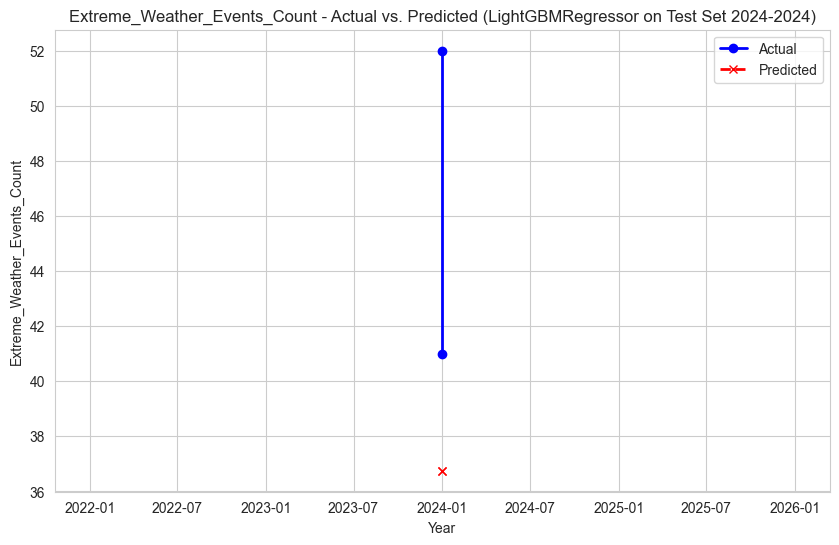

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
  LSTM (Test Set) - MAE: 15.7908, RMSE: 19.7131, R2: -11.8465


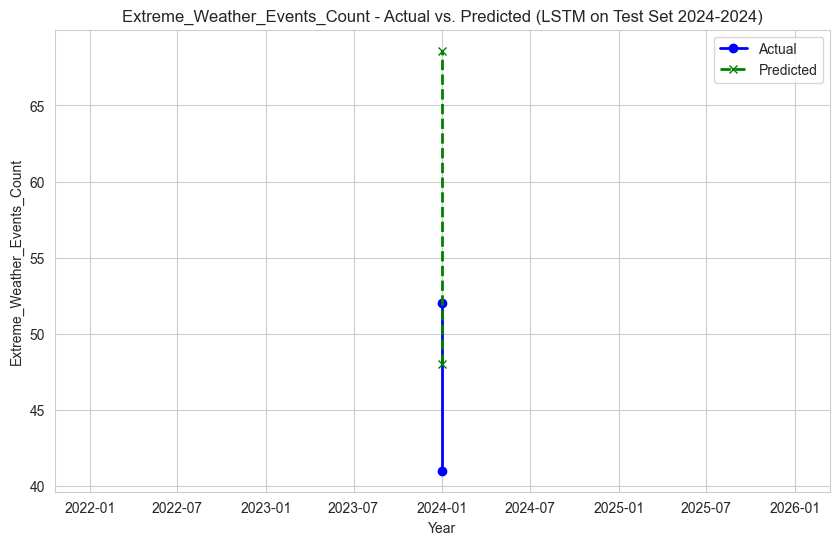


Summary of all test set evaluations:
Temperature_Anomaly_C_LinearRegression: MAE=44.2449, RMSE=44.4910, R2: -791779.6528
Temperature_Anomaly_C_DecisionTreeRegressor: MAE=34.8000, RMSE=35.0349, R2: -490976.0000
Temperature_Anomaly_C_RandomForestRegressor: MAE=38.8300, RMSE=38.8330, R2: -603198.7200
Temperature_Anomaly_C_XGBoostRegressor: MAE=44.7989, RMSE=44.7990, R2: -802777.7192
Temperature_Anomaly_C_LightGBMRegressor: MAE=35.5500, RMSE=35.5500, R2: -505521.0000
Temperature_Anomaly_C_LSTM: MAE=0.0916, RMSE=0.0972, R2: -2.7797
Sea_Level_Rise_mm_LinearRegression: MAE=5.0551, RMSE=6.3099, R2: 0.4489
Sea_Level_Rise_mm_DecisionTreeRegressor: MAE=14.5000, RMSE=19.1442, R2: -4.0727
Sea_Level_Rise_mm_RandomForestRegressor: MAE=10.4700, RMSE=13.7610, R2: -1.6210
Sea_Level_Rise_mm_XGBoostRegressor: MAE=8.5000, RMSE=9.6182, R2: -0.2804
Sea_Level_Rise_mm_LightGBMRegressor: MAE=13.7500, RMSE=16.1652, R2: -2.6168
Sea_Level_Rise_mm_LSTM: MAE=20.5290, RMSE=20.8494, R2: -5.0166
Extreme_Weather_Events

In [23]:
# --- Section 7: Model Evaluation ---
# This section evaluates the trained models on the independent test set.

print("\n--- Section 7: Model Evaluation ---")

evaluation_results = {}

if X_test_processed_df.empty or Y_test.empty:
    print("Test set is empty. Skipping model evaluation on test set.")
else:
    for label in labels_for_models:
        print(f"\n--- Evaluating models for label: {label} on Test Set ---")
        y_test = Y_test[label]
        current_X_test_df = X_test_processed_df.copy()

        # Prepare LSTM test data if applicable
        if LSTM_AVAILABLE:
            n_features_lstm = current_X_test_df.shape[1]
            X_test_lstm = current_X_test_df.values.reshape(current_X_test_df.shape[0], 1, n_features_lstm)

        # Evaluate Traditional ML Models
        for model_name, model_instance in models.items():
            model_key = f'{label}_{model_name}'
            if model_key in trained_models:
                trained_model = trained_models[model_key]
                test_preds = trained_model.predict(current_X_test_df)

                mae = mean_absolute_error(y_test, test_preds)
                rmse = np.sqrt(mean_squared_error(y_test, test_preds))
                r2 = r2_score(y_test, test_preds)

                evaluation_results[model_key] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
                print(f"  {model_name} (Test Set) - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

                # Visualize Model Performance (Predicted vs. Actual on Test Set)
                plt.figure(figsize=(10, 6))
                plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o')
                plt.plot(y_test.index, test_preds, label='Predicted', color='red', linestyle='--', marker='x')
                plt.title(f'{label} - Actual vs. Predicted ({model_name} on Test Set {X_test.index.min().year}-{X_test.index.max().year})')
                plt.xlabel('Year')
                plt.ylabel(label)
                plt.legend()
                plt.grid(True)
                plt.show()
            else:
                print(f"  Model {model_key} not trained, skipping test evaluation.")

        # Evaluate LSTM Model
        if LSTM_AVAILABLE:
            lstm_model_key = f'{label}_LSTM'
            if lstm_model_key in trained_models:
                trained_lstm_model = trained_models[lstm_model_key]
                test_preds_lstm = trained_lstm_model.predict(X_test_lstm).flatten()

                mae_lstm = mean_absolute_error(y_test, test_preds_lstm)
                rmse_lstm = np.sqrt(mean_squared_error(y_test, test_preds_lstm))
                r2_lstm = r2_score(y_test, test_preds_lstm)

                evaluation_results[lstm_model_key] = {'MAE': mae_lstm, 'RMSE': rmse_lstm, 'R2': r2_lstm}
                print(f"  LSTM (Test Set) - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}, R2: {r2_lstm:.4f}")

                plt.figure(figsize=(10, 6))
                plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o')
                plt.plot(y_test.index, test_preds_lstm, label='Predicted', color='green', linestyle='--', marker='x')
                plt.title(f'{label} - Actual vs. Predicted (LSTM on Test Set {X_test.index.min().year}-{X_test.index.max().year})')
                plt.xlabel('Year')
                plt.ylabel(label)
                plt.legend()
                plt.grid(True)
                plt.show()
            else:
                print(f"  Model {lstm_model_key} not trained, skipping test evaluation.")

    print("\nSummary of all test set evaluations:")
    for model_label, metrics in evaluation_results.items():
        print(f"{model_label}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R2: {metrics['R2']:.4f}")

# Cross-validation (Conceptual for time series)
print("\n--- Cross-validation Note ---")
print("For time series, traditional K-fold cross-validation is usually avoided due to data leakage.")
print("Instead, TimeSeriesSplit or a fixed train-validation-test split (as done here) is preferred.")
print("If using GridSearchCV for hyperparameter tuning, you would pass `cv=TimeSeriesSplit()`.")

In [ ]:
# --- Section 8: Future Projections ---
# This section uses the trained model to make future projections beyond the historical data.

print("\n--- Section 8: Future Projections ---")

# Select the best model for each label based on test set performance
# For demonstration, let's assume LightGBM is chosen for all.
# You would manually update this dictionary based on `evaluation_results`
best_models_for_projection = {}
for label in labels_for_models:
    if f'{label}_LightGBMRegressor' in trained_models:
        best_models_for_projection[label] = trained_models[f'{label}_LightGBMRegressor']
    elif f'{label}_RandomForestRegressor' in trained_models: # Fallback if LightGBM wasn't trained or is bad
        best_models_for_projection[label] = trained_models[f'{label}_RandomForestRegressor']
    elif f'{label}_LSTM' in trained_models and LSTM_AVAILABLE: # Consider LSTM if available and good
        best_models_for_projection[label] = trained_models[f'{label}_LSTM']
    else:
        print(f"Warning: No suitable model found for projection for label: {label}. Skipping projection for this label.")
        best_models_for_projection[label] = None # Mark as no model for this label

if not best_models_for_projection:
    print("No models available for projection. Skipping future projections.")
else:
    # Define the years for which you want to make future projections (e.g., 10 years into the future)
    projection_start_year = df_fe.index.max().year + 1
    projection_end_year = projection_start_year + 9 # Project 10 years into the future
    future_projection_years = pd.to_datetime(np.arange(projection_start_year, projection_end_year + 1), format='%Y')

    # Function to generate synthetic future features for projection
    def generate_synthetic_future_features(start_year, end_year, last_historical_data_row_df, initial_features_list, all_engineered_features, lag_periods, rolling_windows, scaler_obj, pca_obj=None, monthly_cols_for_pca=None, scenario_type='baseline'):
        """
        Generates synthetic future features, including lags and rolling stats, for projection.
        This function simulates future values for your input features based on a scenario.
        """
        future_years_range = pd.to_datetime(np.arange(start_year, end_year + 1), format='%Y')
        
        # Initialize DataFrame for future raw features (non-lagged)
        future_raw_features = pd.DataFrame(index=future_years_range, columns=initial_features_list, dtype=float)

        # Populate non-lagged features based on simple trends from the last historical point
        # Ensure last_historical_data_row_df is not empty
        if last_historical_data_row_df.empty:
            print("Error: last_historical_data_row_df is empty. Cannot generate future features.")
            return pd.DataFrame(columns=all_engineered_features) # Return empty DataFrame

        last_hist_year = last_historical_data_row_df.index[0].year
        
        for year_dt in future_years_range:
            year = year_dt.year
            years_from_last_actual = year - last_hist_year
            
            for feature_col in initial_features_list:
                if feature_col not in last_historical_data_row_df.columns:
                    # print(f"Warning: Feature '{feature_col}' not found in last_historical_data_row_df. Skipping synthetic generation for it.")
                    continue
                
                last_val = last_historical_data_row_df.iloc[0][feature_col]
                last_val = float(last_val) # Ensure it's a float
                
                # --- Define your synthetic projection rules for each base feature ---
                # These are illustrative. Replace with real scientific scenarios (SSPs) if possible.
                if scenario_type == 'baseline':
                    if feature_col == 'Avg_Temperature_C':
                        future_raw_features.at[year_dt, feature_col] = last_val + years_from_last_actual * 0.04 # Moderate increase
                    elif feature_col == 'CO2_Emissions_Per_Capita':
                        future_raw_features.at[year_dt, feature_col] = last_val + years_from_last_actual * 0.01 # Slight increase
                    elif feature_col == 'Rainfall_mm':
                        future_raw_features.at[year_dt, feature_col] = last_val + years_from_last_actual * 8 # Slight increase
                    elif feature_col == 'Population':
                        future_raw_features.at[year_dt, feature_col] = last_val * (1 + years_from_last_actual * 0.006) # ~0.6% annual growth
                    elif feature_col == 'Renewable_Energy_pct':
                        future_raw_features.at[year_dt, feature_col] = last_val + years_from_last_actual * 2.0 # Moderate renewable growth
                    elif feature_col == 'Forest_Area_pct':
                        future_raw_features.at[year_dt, feature_col] = last_val - years_from_last_actual * 0.02 # Slight deforestation
                    else:
                        future_raw_features.at[year_dt, feature_col] = last_val # Default to constant
                elif scenario_type == 'aggressive':
                    if feature_col == 'Avg_Temperature_C':
                        future_raw_features.at[year_dt, feature_col] = last_val + years_from_last_actual * 0.01 # Slower temp increase
                    elif feature_col == 'CO2_Emissions_Per_Capita':
                        future_raw_features.at[year_dt, feature_col] = last_val - years_from_last_actual * 0.02 # Significant decrease
                    elif feature_col == 'Rainfall_mm':
                        future_raw_features.at[year_dt, feature_col] = last_val + years_from_last_actual * 2 # Reduced rainfall increase
                    elif feature_col == 'Renewable_Energy_pct':
                        future_raw_features.at[year_dt, feature_col] = last_val + years_from_last_actual * 3.0 # Faster renewable growth
                    elif feature_col == 'Forest_Area_pct':
                        future_raw_features.at[year_dt, feature_col] = last_val + years_from_last_actual * 0.05 # Forest restoration
                    else: # Other features follow baseline or remain constant
                        future_raw_features.at[year_dt, feature_col] = last_val
                        if feature_col == 'Population':
                            future_raw_features.at[year_dt, feature_col] = last_val * (1 + years_from_last_actual * 0.005)
                # Add more scenarios as needed

        # --- Reconstruct full feature set including lags, rolling stats, and PCs ---
        # This is a critical step for time series forecasting:
        # Future lagged features depend on previous *actual or predicted* values.
        # For simplicity here, we'll chain from the last historical actuals.

        # Ensure all columns needed for combined_for_fe are present in last_historical_data_row_df
        cols_needed_for_combined = list(set(initial_features_list + ['Temperature_Anomaly_C'] + (monthly_cols_for_pca if monthly_cols_for_pca else [])))
        cols_needed_for_combined = [col for col in cols_needed_for_combined if col in last_historical_data_row_df.columns]

        # Create a combined DataFrame for feature engineering (historical + future raw)
        combined_for_fe = pd.concat([last_historical_data_row_df[cols_needed_for_combined], future_raw_features]).astype(float)

        # 1. Add Year_Numerical
        combined_for_fe['Year_Numerical'] = combined_for_fe.index.year - df_fe.index.min().year

        # 2. Add Lagged Features
        features_to_lag_combined = [col for col in initial_features_list + ['Temperature_Anomaly_C'] if col in combined_for_fe.columns]
        for lag in lag_periods:
            for feature in features_to_lag_combined:
                combined_for_fe[f'{feature}_lag_{lag}'] = combined_for_fe[feature].shift(lag)

        # 3. Add Rolling Averages/Statistics
        if 'Temperature_Anomaly_C' in combined_for_fe.columns:
            for window in rolling_windows:
                combined_for_fe[f'Temperature_Anomaly_C_rolling_mean_{window}yr'] = combined_for_fe['Temperature_Anomaly_C'].rolling(window=window).mean().shift(1)
                combined_for_fe[f'Temperature_Anomaly_C_rolling_std_{window}yr'] = combined_for_fe['Temperature_Anomaly_C'].rolling(window=window).std().shift(1)

        # 4. Add PCA Components
        '''if pca_obj and monthly_cols_for_pca and all(col in combined_for_fe.columns for col in monthly_cols_for_pca):
            monthly_data_for_pca_combined = combined_for_fe[monthly_cols_for_pca].copy()
            monthly_data_for_pca_combined = monthly_data_for_pca_combined.fillna(monthly_data_for_pca_combined.mean())
            scaled_monthly_for_pca = scaler_monthly_pca.transform(monthly_data_for_pca_combined) # Use fitted scaler_monthly_pca
            
            principal_components_combined = pca_obj.transform(scaled_monthly_for_pca)
            for i in range(pca_obj.n_components_):
                combined_for_fe[f'PC{i+1}'] = principal_components_combined[:, i]'''

        # Select only the features that were used for training the model
        # Drop rows with NaNs (first few years due to lags/rolling)
        X_future_raw = combined_for_fe.loc[future_years_range].dropna(subset=all_engineered_features)
        
        # Ensure all columns are present and in the correct order for the preprocessor
        # Fill any missing columns (e.g., if a PC was not generated) with 0 or NaN
        for col in all_engineered_features:
            if col not in X_future_raw.columns:
                X_future_raw[col] = np.nan # Or 0, depending on expected behavior
        X_future_raw = X_future_raw[all_engineered_features].astype(float)

        return X_future_raw

    # Get the last known historical data row as a DataFrame for feature generation
    # Ensure all columns needed for future feature generation are present in this row
    cols_for_last_row_df = []
    cols_for_last_row_df.extend(existing_features) # Base features
    if 'Temperature_Anomaly_C' in df_fe.columns:
        cols_for_last_row_df.append('Temperature_Anomaly_C')
    '''if existing_monthly_cols:
        cols_for_last_row_df.extend(existing_monthly_cols)'''

    # Filter to ensure only columns present in df_fe are selected for the last row
    cols_for_last_row_df = [col for col in cols_for_last_row_df if col in df_fe.columns]

    if df_fe.empty:
        print("Error: df_fe is empty after feature engineering and NaN handling. Cannot generate future projections.")
    else:
        last_historical_data_row_df = df_fe.loc[[df_fe.index.max()]][cols_for_last_row_df].astype(float)

        if last_historical_data_row_df.empty:
            print("Error: last_historical_data_row_df is empty. This indicates an issue with column selection or remaining data.")
        else:
            # Generate future features for the baseline scenario
            X_future_baseline_raw = generate_synthetic_future_features(
                projection_start_year, projection_end_year,
                last_historical_data_row_df,
                existing_features, # Base features
                final_features_for_modeling, # All engineered features
                lag_periods, rolling_windows,
                scaler_obj=None, # Not directly used in this function, but passed for consistency
                pca_obj=pca if 'pca' in locals() else None,
                #monthly_cols_for_pca=existing_monthly_cols if existing_monthly_cols else None,
                scenario_type='baseline'
            )

            if not X_future_baseline_raw.empty:
                # Preprocess the future input data using the *same fitted preprocessor*
                X_future_processed_df_baseline = pd.DataFrame(
                    preprocessor.transform(X_future_baseline_raw.values.astype(np.float64)),
                    columns=final_features_for_modeling,
                    index=X_future_baseline_raw.index
                )

                print("\nSynthetic Future Input Features (Processed for Baseline Scenario):")
                print(X_future_processed_df_baseline.head())

                # Make Projections for each label
                future_projections_baseline = pd.DataFrame(index=X_future_processed_df_baseline.index)

                for label, model in best_models_for_projection.items():
                    if model is None:
                        future_projections_baseline[label] = np.nan
                        continue

                    if 'LSTM' in str(type(model)):
                        n_features_lstm = X_future_processed_df_baseline.shape[1]
                        X_future_lstm = X_future_processed_df_baseline.values.reshape(X_future_processed_df_baseline.shape[0], 1, n_features_lstm)
                        future_preds = model.predict(X_future_lstm).flatten()
                    else:
                        future_preds = model.predict(X_future_processed_df_baseline)
                    
                    future_projections_baseline[label] = future_preds

                # Post-process predictions (e.g., ensure non-negative counts)
                if 'Extreme_Weather_Events_Count' in future_projections_baseline.columns:
                    future_projections_baseline['Extreme_Weather_Events_Count'] = future_projections_baseline['Extreme_Weather_Events_Count'].round().astype(int).clip(lower=0)

                print("\n--- Final Future Projections (Baseline Scenario) ---")
                print(future_projections_baseline)

                # Visualize Projections vs. Historical Data (Baseline)
                for label in labels_for_models:
                    plt.figure(figsize=(12, 7))
                    # Plot historical data (train, val, test)
                    plt.plot(Y_train.index, Y_train[label], label='Historical Actuals (Train)', color='green', alpha=0.7)
                    if not Y_val.empty:
                        plt.plot(Y_val.index, Y_val[label], label='Historical Actuals (Validation)', color='orange', alpha=0.7)
                    if not Y_test.empty:
                        plt.plot(Y_test.index, Y_test[label], label='Historical Actuals (Test)', color='blue', marker='o', markersize=4)
                    
                    # Plot future projections
                    plt.plot(future_projections_baseline.index, future_projections_baseline[label],
                            label='Future Projections (Baseline)', color='red', linestyle='--', marker='x', markersize=4)
                    
                    plt.title(f'Historical and Projected {label} for India (Baseline Scenario)', fontsize=16)
                    plt.xlabel('Year', fontsize=12)
                    plt.ylabel(label, fontsize=12)
                    plt.axvline(x=df_fe.index.max(), color='gray', linestyle=':', label='Projection Start')
                    plt.legend()
                    plt.grid(True)
                    plt.show()
            else:
                print("X_future_baseline_raw is empty. Cannot make baseline projections.")


    # --- Section 9: Scenario Analysis ---
    # This section conducts scenario analysis to understand the impact of different factors.

    print("\n--- Section 9: Scenario Analysis ---")
    print("Demonstrating 'Aggressive Emission Reduction' Scenario.")
    def generate_aggressive_future_features(start_year, end_year, last_historical_data_row_df, initial_features_list, all_engineered_features, lag_periods, rolling_windows, scaler_obj, pca_obj=None, scenario_type='aggressive'):
      """
      Generates synthetic future features, including lags and rolling stats, for projection.
      This function simulates future values for your input features based on an 'aggressive emission reduction' scenario.
      """
      future_years_range = pd.to_datetime(np.arange(start_year, end_year + 1), format='%Y')
      future_raw_features = pd.DataFrame(index=future_years_range, columns=initial_features_list, dtype=float)

      last_hist_year = last_historical_data_row_df.index[0].year
    
      for year_dt in future_years_range:
          year = year_dt.year
          years_from_last_actual = year - last_hist_year
        
          for feature_col in initial_features_list:
              # Ensure feature_col exists in the last_historical_data_row_df
              if feature_col not in last_historical_data_row_df.columns:
                  continue # Skip if the feature column isn't in the historical data
            
              last_val = last_historical_data_row_df.iloc[0][feature_col]
              last_val = float(last_val) # Ensure it's a float
            
              # --- Define aggressive emission reduction rules ---
              if feature_col == 'Avg_Temperature_C':
                  future_raw_features.at[year_dt, feature_col] = last_val + years_from_last_actual * 0.01 # Slower temp increase
              elif feature_col == 'CO2_Emissions_Per_Capita':
                  future_raw_features.at[year_dt, feature_col] = last_val - years_from_last_actual * 0.02 # Significant decrease
              elif feature_col == 'Rainfall_mm':
                  future_raw_features.at[year_dt, feature_col] = last_val + years_from_last_actual * 2 # Reduced rainfall increase
              elif feature_col == 'Renewable_Energy_pct':
                  future_raw_features.at[year_dt, feature_col] = last_val + years_from_last_actual * 3.0 # Faster renewable growth
              elif feature_col == 'Forest_Area_pct':
                  future_raw_features.at[year_dt, feature_col] = last_val + years_from_last_actual * 0.05 # Forest restoration
              else: # Other features follow baseline or remain constant
                  future_raw_features.at[year_dt, feature_col] = last_val
                  if feature_col == 'Population':
                      future_raw_features.at[year_dt, feature_col] = last_val * (1 + years_from_last_actual * 0.005)
                  # Add more specific rules for other features if needed for this scenario
    
      # --- Reconstruct full feature set including lags, rolling stats, and PCs for this scenario ---
      # Ensure all columns needed for combined_for_fe are present in last_historical_data_row_df
      cols_needed_for_combined = list(set(initial_features_list + ['Temperature_Anomaly_C']))
      cols_needed_for_combined = [col for col in cols_needed_for_combined if col in last_historical_data_row_df.columns]

      # Create a combined DataFrame for feature engineering (historical + future raw)
      combined_for_fe = pd.concat([last_historical_data_row_df[cols_needed_for_combined], future_raw_features]).astype(float)

      # 1. Add Year_Numerical
      # Ensure df_fe.index.min().year is accessible (implies df_fe is not empty)
      min_year_for_numerical = df_fe.index.min().year if not df_fe.empty else combined_for_fe.index.min().year
      combined_for_fe['Year_Numerical'] = combined_for_fe.index.year - min_year_for_numerical

      # 2. Add Lagged Features
      features_to_lag_combined = [col for col in initial_features_list + ['Temperature_Anomaly_C'] if col in combined_for_fe.columns]
      for lag in lag_periods:
          for feature in features_to_lag_combined:
              combined_for_fe[f'{feature}_lag_{lag}'] = combined_for_fe[feature].shift(lag)

      # 3. Add Rolling Averages/Statistics
      if 'Temperature_Anomaly_C' in combined_for_fe.columns:
          for window in rolling_windows:
              combined_for_fe[f'Temperature_Anomaly_C_rolling_mean_{window}yr'] = combined_for_fe['Temperature_Anomaly_C'].rolling(window=window).mean().shift(1)
              combined_for_fe[f'Temperature_Anomaly_C_rolling_std_{window}yr'] = combined_for_fe['Temperature_Anomaly_C'].rolling(window=window).std().shift(1)

      # 4. Add PCA Components
      '''if pca_obj and monthly_cols_for_pca and all(col in combined_for_fe.columns for col in monthly_cols_for_pca):
          monthly_data_for_pca_combined = combined_for_fe[monthly_cols_for_pca].copy()
          monthly_data_for_pca_combined = monthly_data_for_pca_combined.fillna(monthly_data_for_pca_combined.mean())
          #scaled_monthly_for_pca = scaler_monthly_pca.transform(monthly_data_for_pca_combined) # Use fitted scaler_monthly_pca
        
          principal_components_combined = pca_obj.transform(scaled_monthly_for_pca)
          for i in range(pca_obj.n_components_):
              combined_for_fe[f'PC{i+1}'] = principal_components_combined[:, i]'''

      # Select only the features that were used for training the model
      # Drop rows with NaNs (first few years due to lags/rolling)
      X_future_raw = combined_for_fe.loc[future_years_range].dropna(subset=all_engineered_features)
    
      # Ensure all columns are present and in the correct order for the preprocessor
      # Fill any missing columns (e.g., if a PC was not generated) with 0 or NaN
      for col in all_engineered_features:
          if col not in X_future_raw.columns:
              X_future_raw[col] = np.nan # Or 0, depending on expected behavior
      X_future_raw = X_future_raw[all_engineered_features].astype(float)

      return X_future_raw


    # Generate future features for the aggressive reduction scenario
    X_future_aggressive_raw = generate_aggressive_future_features(
        projection_start_year, projection_end_year,
        last_historical_data_row_df,
        existing_features,
        final_features_for_modeling,
        lag_periods, rolling_windows,
        scaler_obj=None,
        pca_obj=pca if 'pca' in locals() else None,
        #monthly_cols_for_pca=existing_monthly_cols if existing_monthly_cols else None,
        scenario_type='aggressive'
    )

    if not X_future_aggressive_raw.empty:
        # Preprocess the aggressive scenario input data
        X_future_processed_df_aggressive = pd.DataFrame(
            preprocessor.transform(X_future_aggressive_raw.values.astype(np.float64)),
            columns=final_features_for_modeling,
            index=X_future_aggressive_raw.index
        )

        print("\nSynthetic Future Input Features (Processed for Aggressive Reduction Scenario):")
        print(X_future_processed_df_aggressive.head())

        # Make Projections for aggressive scenario
        future_projections_aggressive = pd.DataFrame(index=X_future_processed_df_aggressive.index)

        for label, model in best_models_for_projection.items():
            if model is None:
                future_projections_aggressive[label] = np.nan
                continue

            if 'LSTM' in str(type(model)):
                n_features_lstm = X_future_processed_df_aggressive.shape[1]
                X_future_lstm_aggressive = X_future_processed_df_aggressive.values.reshape(X_future_processed_df_aggressive.shape[0], 1, n_features_lstm)
                future_preds = model.predict(X_future_lstm_aggressive).flatten()
            else:
                future_preds = model.predict(X_future_processed_df_aggressive)
            
            future_projections_aggressive[label] = future_preds

        if 'Extreme_Weather_Events_Count' in future_projections_aggressive.columns:
            future_projections_aggressive['Extreme_Weather_Events_Count'] = future_projections_aggressive['Extreme_Weather_Events_Count'].round().astype(int).clip(lower=0)

        print("\n--- Final Future Projections (Aggressive Emission Reduction Scenario) ---")
        print(future_projections_aggressive)

        # --- Visualize Comparison of Scenarios ---
        print("\n--- Visualizing Scenario Comparison ---")
        for label in labels_for_models:
            plt.figure(figsize=(12, 7))
            # Plot historical data
            plt.plot(Y_train.index, Y_train[label], label='Historical Actuals (Train)', color='green', alpha=0.7)
            if not Y_val.empty:
                plt.plot(Y_val.index, Y_val[label], label='Historical Actuals (Validation)', color='orange', alpha=0.7)
            if not Y_test.empty:
                plt.plot(Y_test.index, Y_test[label], label='Historical Actuals (Test)', color='blue', marker='o', markersize=4)
            
            # Plot future projections for both scenarios
            plt.plot(future_projections_baseline.index, future_projections_baseline[label],
                    label='Future Projections (Baseline)', color='red', linestyle='--', marker='x', markersize=4)
            plt.plot(future_projections_aggressive.index, future_projections_aggressive[label],
                    label='Future Projections (Aggressive Reduction)', color='purple', linestyle=':', marker='^', markersize=4)
            
            plt.title(f'Historical and Projected {label} for India (Scenario Comparison)', fontsize=16)
            plt.xlabel('Year', fontsize=12)
            plt.ylabel(label, fontsize=12)
            plt.axvline(x=df_fe.index.max(), color='gray', linestyle=':', label='Projection Start')
            plt.legend()
            plt.grid(True)
            plt.show()
    else:
        print("X_future_aggressive_raw is empty. Cannot make aggressive scenario projections.")


print("\n--- End of Project Implementation ---")
print("For real-world validation, comparing projections with published scientific reports (e.g., IPCC).")
print("Sections 10 (Deployment) and 11 (Documentation) are conceptual steps beyond this code output.")



--- Section 8: Future Projections ---


NameError: name 'existing_monthly_cols' is not defined